#**Импорты**

In [315]:
!pip install ydata_profiling

In [316]:
!pip install phik

In [317]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import phik

from ydata_profiling import ProfileReport
from IPython.display import display, HTML
from scipy.stats import chi2_contingency
from matplotlib.colors import LinearSegmentedColormap
from phik import report

#**Функции**

##**Фомирование табличного отчета (DataFrame) статистической сводки**

**Описание:** Создает DataFrame с основными описательными статистиками признака. Используется для численного анализа распределения, поиска выбросов и пропусков. Возвращает стандартный датафрейм со всеми ключевыми метриками.

In [318]:
def get_numerical_summary(df: pd.DataFrame, feature_name: str, unit: str) -> pd.DataFrame:
    if feature_name not in df.columns:
        return pd.DataFrame({"Ошибка": [f"Признак {feature_name} не найден"]})

    series = df[feature_name].dropna()

    q1, q3 = series.quantile(0.25), series.quantile(0.75)
    iqr = q3 - q1
    low, high = q1 - 1.5 * iqr, q3 + 1.5 * iqr

    stats_data = {
        "Метрика": [
            "Общее количество", "Пропущенные значения", "Процент пропусков (%)",
            "Среднее (Mean)", "Медиана (Median)", "Стандартное отклонение",
            "Дисперсия", "Минимум", "Максимум", "Скошенность (Skewness)",
            "Эксцесс (Kurtosis)", "Количество выбросов", "Нижняя граница", "Верхняя граница"
        ],
        f"Значение ({unit})": [
            len(df), df[feature_name].isna().sum(), (df[feature_name].isna().sum() / len(df)) * 100,
            series.mean(), series.median(), series.std(), series.var(),
            series.min(), series.max(), series.skew(), series.kurt(),
            len(series[(series < low) | (series > high)]), low, high
        ]
    }

    res_df = pd.DataFrame(stats_data)
    res_df[f"Значение ({unit})"] = res_df[f"Значение ({unit})"].apply(
        lambda x: round(x, 1) if isinstance(x, (int, float)) else x
    )
    return res_df

##**Функция для графического анализа распределения (Seaborn)**

**Описание:** Функция строит комбинированный график, включающий гистограмму и кривую оценки плотности ядра (KDE) для анализа формы распределения числового признака.


In [319]:
def plot_numerical_distribution(df: pd.DataFrame, feature_name: str, unit: str):
    if feature_name not in df.columns:
        print(f"Ошибка: Признак {feature_name} не найден")
        return

    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams['font.family'] = 'sans-serif'
    plt.figure(figsize=(10, 5))

    # Гистограмма и плотность
    sns.histplot(
        df[feature_name],
        bins=40,
        kde=True,
        color='#4682B4',
        edgecolor='white',
        alpha=0.6,
        line_kws={'linewidth': 2}
    )

    # Среднее и медиана
    mean_val = df[feature_name].mean()
    median_val = df[feature_name].median()

    plt.axvline(mean_val, color='#FF6347', linestyle='--', linewidth=2,
                label=f'Среднее: {mean_val:.1f}')
    plt.axvline(median_val, color='#2ECC71', linestyle='-', linewidth=2,
                label=f'Медиана: {median_val:.1f}')

    plt.title(f'Распределение: {feature_name}', fontsize=14, pad=20)
    plt.xlabel(f'{feature_name} ({unit})', fontsize=11)
    plt.ylabel('Частота', fontsize=11)

    plt.legend(frameon=True, loc='upper right')
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

##**Анализ взаимосвязи числовых признаков с целевой переменной**

**Описани:**

- **Скрипичная визуализация (Violin Plot):** Функция создает скрипичные графики, которые позволяют одновременно оценить плотность распределения и квартили числового признака для каждой категории веса, выявляя скрытые закономерности в данных.

- **Статистическая сводка:** Инструмент `get_feature_target_pivot` формирует детализированную таблицу агрегированных показателей (среднее, медиана, стандартное отклонение), позволяя подтвердить визуальные тренды точными цифрами.

- **Сравнительный анализ:** Комбинация графического и табличного методов обеспечивает комплексную оценку того, как меняются параметры организма или привычки питания (например, возраст или потребление воды) при переходе от дефицита веса к различным стадиям ожирения.


In [320]:
def plot_feature_by_target_dark(df: pd.DataFrame, feature_name: str, unit: str):
    """
    УНИВЕРСАЛЬНЫЙ СКРИПИЧНЫЙ ГРАФИК
    """
    if feature_name not in df.columns:
        return

    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid", {'axes.grid': False})
    plt.rcParams['font.family'] = 'sans-serif'

    sns.violinplot(
        data=df,
        x='NObeyesdad',
        y=feature_name,
        color='#003366',
        inner="quartile",
        linewidth=1.5,
        edgecolor='white',
        alpha=0.8,
        cut=0
    )

    plt.title(f'Анализ распределения: {feature_name}', fontsize=14, pad=20)
    plt.xlabel('Категория веса', fontsize=11)
    plt.ylabel(f'{feature_name} ({unit})', fontsize=11)
    plt.xticks(rotation=45, ha='right')

    plt.grid(axis='y', linestyle=':', alpha=0.3)
    sns.despine(left=True)
    plt.tight_layout()
    plt.show()

def get_feature_target_pivot(df: pd.DataFrame, feature_name: str):
    """Сводная таблица по категориям веса."""
    pivot = df.groupby('NObeyesdad')[feature_name].agg([
        'count', 'mean', 'median', 'std', 'min', 'max'
    ]).round(1)
    pivot.columns = ['Кол-во', 'Среднее', 'Медиана', 'Std', 'Мин', 'Макс']
    return pivot.sort_values(by='Медиана')

##**Анализ распределения категориальных признаков**

**Описание:**
* Создает интерактивные HTML-таблицы с группировкой по признакам. Подсвечивает наиболее часто встречающиеся значения (**Моду**) и рассчитывает **Дисбаланс** (соотношение самого частого класса к самому редкому).
* Строит несколько столбчатых диаграмм в ряд, автоматически подстраивая их размер. Это позволяет сравнивать распределения разных признаков на одном экране.
* Над каждым столбцом выводит точное значение в процентах, а длинные названия ответов внизу поворачивает под углом 45°, чтобы они не накладывались друг на друга.
* Приводит все графики к единому «чистому» виду без лишних рамок и сеток, убирая черную обводку для соответствия современным стандартам визуализации данных.

In [321]:
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['font.family'] = 'sans-serif'

custom_style = """
<style>
    .analysis-container { width: 95%; margin: 20px auto; font-family: Arial, sans-serif; }
    .ordinal-table { width: 100%; border-collapse: collapse; margin: 10px 0; font-size: 14px; }
    .ordinal-table th { background: #495057; color: white; padding: 12px 8px; text-align: center; font-weight: 800; }
    .ordinal-table td { padding: 10px 8px; border: 1px solid #dee2e6; text-align: center; font-weight: 600; }
    .mode-highlight { background-color: #e9ecef !important; font-weight: 700; }
</style>
"""

def generate_styled_table(df, title):
    html = f'<div class="analysis-container"><h3 style="background:#f8f9fa; padding:10px; border:2px solid #333; border-radius:8px;">{title}</h3>'
    html += '<table class="ordinal-table"><thead><tr>'
    for col in ['Признак', 'Класс', 'Количество', 'Процент (%)', 'Мода', 'Дисбаланс']:
        html += f'<th>{col}</th>'
    html += '</tr></thead><tbody>'

    for feat in df['Признак'].unique():
        sub = df[df['Признак'] == feat]
        for i, (_, row) in enumerate(sub.iterrows()):
            row_style = 'class="mode-highlight"' if i == 0 else ''
            html += f'<tr {row_style}>'
            if i == 0:
                html += f'<td rowspan="{len(sub)}" style="text-align:left; font-weight:700;">{feat}</td>'
            html += f'<td style="text-align:left;">{row["Класс"]}</td>'
            html += f'<td>{row["Количество"]:,}</td><td>{row["Процент (%)"]}%</td>'
            if i == 0:
                html += f'<td rowspan="{len(sub)}">{row["Мода"]}</td>'
                html += f'<td rowspan="{len(sub)}">{row["Дисбаланс"]}</td>'
            html += '</tr>'
    return html + "</tbody></table></div>"

def plot_categorical_grid(df, features, translations, colors='#4682B4'):
    n_feat = len(features)
    fig, axes = plt.subplots(1, n_feat, figsize=(n_feat * 4, 5))
    if n_feat == 1: axes = [axes]

    for ax, feat in zip(axes, features):
        data = df[feat].value_counts().sort_index()

        sns.barplot(x=data.index, y=data.values, ax=ax, color=colors, alpha=0.7, edgecolor=None)

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = f'{100 * height / total:.1f}%'
                ax.annotate(percentage, (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', xytext=(0, 5),
                            textcoords='offset points', fontsize=9)

        ax.set_title(f'{translations.get(feat, feat)}', fontsize=12, pad=15)
        ax.set_ylabel('Частота')

        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        sns.despine(ax=ax)

    plt.tight_layout()
    plt.show()

##**Анализ распределения категориальных признаков по переменной таргета (графики)**

**Описание:** Эта функция строит сгруппированные столбчатые диаграммы для визуализации взаимосвязи между категориальными признаками и целевой переменной. Она отображает категории веса по оси X, используя цвета (*hue*) для представления распределения ответов внутри каждой категории, дополняя график процентными метками для точного сравнения.

In [322]:
def plot_target_by_categorical(df, features, target_col='NObeyesdad', translations=None):
    """
    Строит графики, где по оси X идут уровни ожирения,
    а цвета (hue) показывают распределение ответов внутри каждого уровня.
    """
    translations = translations or {}

    for feat in features:
        plt.figure(figsize=(12, 6))

        ax = sns.countplot(
            data=df,
            x=target_col,
            hue=feat,
            palette='Blues_d',
            alpha=0.7,
            edgecolor=None
        )

        total = len(df)
        for p in ax.patches:
            height = p.get_height()
            if height > 0:
                percentage = f'{100 * height / total:.1f}%'
                ax.annotate(percentage,
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom',
                            xytext=(0, 5),
                            textcoords='offset points',
                            fontsize=8)

        feat_name = translations.get(feat, feat)
        plt.title(f'Распределение признака "{feat_name}" по уровням ожирения', fontsize=13, pad=20)
        plt.xlabel('Уровень ожирения (NObeyesdad)', fontsize=11)
        plt.ylabel('Частота')

        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

        plt.legend(title=feat_name, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)

        sns.despine(left=True)
        plt.tight_layout()
        plt.show()

##**Отчет по кодированию**

**Описание:** Функции обеспечивают наглядное представление процесса кодирования признаков, преобразуя внутренние словари препроцессора в структурированные HTML-карточки. Код реализует индивидуальное цветовое кодирование для разных типов преобразований (Ordinal, One-Hot), а также автоматически документирует применение технических параметров, таких как `drop_first=True` для номинальных признаков.


In [323]:
class DataPreprocessor:
    def __init__(self, drop_columns=None):
        self.drop_columns = drop_columns if drop_columns else []
        self.mappings = {}
        self.target_map = {}
        self.ohe_columns = []

    def preprocess(self, df: pd.DataFrame, fit: bool = True) -> pd.DataFrame:
        df_encoded = df.copy()

        df_encoded = df_encoded.drop(columns=self.drop_columns, errors='ignore')

        binary_cols = ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
        binary_map = {'no': 0, 'yes': 1}

        if fit:
            self.mappings['binary'] = {col: binary_map for col in binary_cols if col in df_encoded.columns}

        for col in binary_cols:
            if col in df_encoded.columns:
                mapping = binary_map if fit else self.mappings.get('binary', {}).get(col, binary_map)
                df_encoded[col] = df_encoded[col].map(mapping)

        caec_order = ['no', 'Sometimes', 'Frequently', 'Always']
        calc_order = ['no', 'Sometimes', 'Frequently', 'Always']

        if fit:
            caec_map = {val: idx for idx, val in enumerate(caec_order)}
            calc_map = {val: idx for idx, val in enumerate(calc_order)}
            self.mappings['ordinal'] = {'CAEC': caec_map, 'CALC': calc_map}
        else:
            caec_map = self.mappings.get('ordinal', {}).get('CAEC', {})
            calc_map = self.mappings.get('ordinal', {}).get('CALC', {})

        if 'CAEC' in df_encoded.columns:
            df_encoded['CAEC'] = df_encoded['CAEC'].map(caec_map)
        if 'CALC' in df_encoded.columns:
            df_encoded['CALC'] = df_encoded['CALC'].map(calc_map)

        if 'NObeyesdad' in df_encoded.columns:
            obesity_order = [
                'Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I',
                'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II',
                'Obesity_Type_III'
            ]
            if fit:
                obesity_map = {val: idx for idx, val in enumerate(obesity_order)}
                self.target_map = obesity_map
            else:
                obesity_map = self.target_map
            df_encoded['NObeyesdad'] = df_encoded['NObeyesdad'].map(obesity_map)

        ohe_cols = ['Gender', 'MTRANS']
        if fit:
            for col in ohe_cols:
                if col in df_encoded.columns:
                    unique_vals = sorted(df_encoded[col].unique())
                    actual_dummies = unique_vals[1:]
                    self.ohe_columns.extend([f"{col}_{val}" for val in actual_dummies])

            df_encoded, new_cols_map = self._get_dummies_and_track(df_encoded, columns=ohe_cols, drop_first=True)
            self.mappings['one_hot_cols'] = new_cols_map
        else:
            df_encoded = self._apply_one_hot(df_encoded, ohe_cols)

        for col in df_encoded.columns:
            if df_encoded[col].dtype == 'object' or df_encoded[col].dtype.name == 'category':
                try:
                    df_encoded[col] = pd.to_numeric(df_encoded[col])
                except:
                    pass
        return df_encoded

    def _get_dummies_and_track(self, df, columns, drop_first=True):
        new_cols = {}
        for col in columns:
            if col in df.columns:
                dummies = pd.get_dummies(df[col], prefix=col, drop_first=drop_first)
                df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
                new_cols[col] = dummies.columns.tolist()
        return df, new_cols

    def _apply_one_hot(self, df, columns):
        for col in columns:
            if col in df.columns:
                dummies = pd.get_dummies(df[col], prefix=col)
                expected_cols = [c for c in self.ohe_columns if c.startswith(f"{col}_")]
                for expected in expected_cols:
                    if expected not in dummies.columns:
                        dummies[expected] = 0
                dummies = dummies[expected_cols]
                df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
        return df

    def generate_mapping_report(self) -> pd.DataFrame:
        report = []
        for col, mapping in self.mappings.get('binary', {}).items():
            for key, val in mapping.items():
                report.append({'Признак': col, 'Исходное Значение': key, 'Код': val, 'Метод': 'Binary'})
        for col, mapping in self.mappings.get('ordinal', {}).items():
            for key, val in mapping.items():
                report.append({'Признак': col, 'Исходное Значение': key, 'Код': val, 'Метод': 'Ordinal'})
        for key, val in self.target_map.items():
            report.append({'Признак': 'NObeyesdad (Target)', 'Исходное Значение': key, 'Код': val, 'Метод': 'Ordinal (Target)'})
        for original_col, new_cols in self.mappings.get('one_hot_cols', {}).items():
            for nc in new_cols:
                report.append({'Признак': original_col, 'Исходное Значение': nc.replace(f"{original_col}_", ""), 'Код': 1, 'Метод': f'OHE (Col: {nc})'})

        return pd.DataFrame(report)

In [324]:
def display_horizontal_reports(mapping_dict, title, bg_color='#f0f4f7', text_color='#003366'):
    """
    Создает горизонтальную верстку для словаря маппингов.
    """
    html_output = f"<h3 style='color:#003366; font-family:sans-serif; margin-bottom:15px;'>{title}</h3>"
    html_output += "<div style='display: flex; flex-wrap: wrap; gap: 40px; align-items: flex-start;'>"

    for col, mapping in mapping_dict.items():
        df_rep = pd.DataFrame(list(mapping.items()), columns=['Значение', 'Код'])

        table_html = df_rep.style.hide(axis='index')\
            .set_table_attributes(f"style='border-collapse: collapse; min-width: 150px; font-family: sans-serif;'")\
            .set_properties(**{
                'background-color': bg_color,
                'color': text_color,
                'border': '2px solid white',
                'padding': '8px',
                'text-align': 'center'
            })\
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', text_color), ('color', 'white'), ('font-weight', 'bold'), ('padding', '10px')]}
            ])\
            .to_html()

        html_output += f"""
        <div style='border: 1px solid #d1d8e0; border-radius: 8px; padding: 15px; background-color: #ffffff; box-shadow: 2px 2px 5px rgba(0,0,0,0.05);'>
            <div style='font-weight: bold; color: {text_color}; margin-bottom: 10px; border-bottom: 2px solid {text_color}; padding-bottom: 5px;'>
                {col}
            </div>
            {table_html}
        </div>
        """

    html_output += "</div>"
    display(HTML(html_output))

In [325]:
def display_ohe_reports(preprocessor):
    """Специальная верстка для One-Hot, так как структура данных отличается."""
    ohe_mappings = preprocessor.mappings.get('one_hot_cols', {})

    html_output = "<h3 style='color:#664d00; font-family:sans-serif; margin-bottom:15px;'>ONE-HOT КОДИРОВАНИЕ (NOMINAL FEATURES)</h3>"
    html_output += "<div style='display: flex; flex-wrap: wrap; gap: 40px; align-items: flex-start;'>"

    for original_col, new_cols in ohe_mappings.items():
        ohe_data = []
        for nc in new_cols:
            val = nc.replace(f"{original_col}_", "")
            ohe_data.append({'Исходное значение': val, 'Новая колонка': nc})

        df_rep = pd.DataFrame(ohe_data)

        table_html = df_rep.style.hide(axis='index')\
            .set_table_attributes("style='border-collapse: collapse; min-width: 250px; font-family: sans-serif;'")\
            .set_properties(**{
                'background-color': '#fdf9ee',
                'color': '#664d00',
                'border': '2px solid white',
                'padding': '8px'
            })\
            .set_table_styles([
                {'selector': 'th', 'props': [('background-color', '#664d00'), ('color', 'white'), ('font-weight', 'bold'), ('padding', '10px')]}
            ])\
            .to_html()

        html_output += f"""
        <div style='border: 1px solid #e3d9b1; border-radius: 8px; padding: 15px; background-color: #ffffff; box-shadow: 2px 2px 5px rgba(0,0,0,0.05);'>
            <div style='font-weight: bold; color: #664d00; margin-bottom: 10px; border-bottom: 2px solid #664d00; padding-bottom: 5px;'>
                {original_col} (Dummies)
            </div>
            <p style='font-size: 12px; color: #888;'>Режим: drop_first=True</p>
            {table_html}
        </div>
        """

    html_output += "</div>"
    display(HTML(html_output))

#**Информация об ожирении**

Ожирение детерминируется как мультифакторное хроническое заболевание, характеризующееся патологической пролиферацией жировой ткани. Данное состояние ассоциировано с существенным повышением риска метаболических, кардиоваскулярных и онкологических патологий.

## 1. Антропометрические маркеры и стратификация рисков

Центральным инструментом скрининга в эпидемиологических исследованиях выступает **Индекс массы тела (ИМТ)**. Математическая модель ИМТ определяется как отношение массы тела к квадрату роста:


### Классификация категорий состояния здоровья

В исследуемом наборе данных представлена расширенная иерархия классов, базирующаяся на стандартах ВОЗ, но предлагающая более глубокую дискретизацию степеней ожирения:

| Категория ВОЗ | Диапазон ИМТ (кг/м²) | Соответствие в датасете |
| --- | --- | --- |
| Дефицит массы тела | < 18,5 | **Insufficient_Weight** |
| Нормостения | 18,5 – 24,9 | **Normal_Weight** |
| Предожирение | 25,0 – 29,9 | **Overweight_Level_I / II** |
| Ожирение I степени | 30,0 – 34,9 | **Obesity_Type_I** |
| Ожирение II степени | 35,0 – 39,9 | **Obesity_Type_II** |
| Ожирение III степени | ≥ 40,0 | **Obesity_Type_III** |

Детализация уровней `Overweight` и `Obesity` позволяет алгоритмам более точно идентифицировать переходные состояния и дифференцировать группы риска.

### Топография жировых отложений

Прогностическая ценность ИМТ дополняется анализом локализации адипоцитов, что критично для оценки кардиометаболической нагрузки:

* **Абдоминальный тип («андроидный»):** Характеризуется висцеральным депонированием жира. Обладает высокой эндокринной активностью, провоцируя инсулинорезистентность.
* **Гиноидный тип («периферический»):** Преимущественное отложение в области бедренно-ягодичного сегмента, чаще наблюдаемое у женщин.

## 2. Этиологические факторы и детерминанты данных

Развитие ожирения рассматривается как результат синергии генетической предрасположенности и триггеров внешней среды.

### 2.1. Поведенческие паттерны

Данная группа факторов представлена в датасете наиболее широко, что позволяет моделировать влияние образа жизни:

* **Алиментарный профиль:** Прямое влияние на энергобаланс оказывают частота потребления гиперкалорийной пищи (`FAVC`), удельный вес овощей в рационе (`FCVC`) и паттерны нутритивной нагрузки (`NCP`, `CAEC`).
* **Питьевой режим (`CH2O`):** Адекватная гидратация рассматривается как фактор модуляции чувства насыщения и скорости метаболических реакций.
* **Физическая активность и гиподинамия:** Баланс между физическими нагрузками (`FAF`) и экранным временем (`TUE`) определяет объем энергозатрат.

### 2.2. Биологические и наследственные детерминанты

* **Генетический предиктор (`family_history_with_overweight`):** Является мощным независимым признаком, агрегирующим наследственные особенности метаболизма и паттерны семейного пищевого поведения.
* **Гендерный диморфизм (`Gender`):** Влияет на базовую скорость метаболизма и соотношение мышечной и жировой тканей.

## 3. Аналитическая структура признаков (Feature Engineering)

Для построения высокоточных моделей проведена классификация переменных по их функциональной роли в патогенезе:

| Группа признаков | Переменные | Роль в моделировании |
| --- | --- | --- |
| **Биологические** | `Age`, `Gender`, `Height`, `Weight` | Формирование базового физиологического профиля. |
| **Генетические** | `family_history_with_overweight` | Учет долгосрочной предрасположенности. |
| **Нутритивные** | `FAVC`, `FCVC`, `NCP`, `CAEC`, `CH2O`, `CALC` | Оценка структуры и режима питания. |
| **Активность** | `FAF`, `TUE`, `MTRANS` | Оценка уровня гиподинамии и образа жизни. |

### Особенности (Interaction Effects)

1. **Интерпретация `Gender`:** При идентичных показателях ИМТ риск развития осложнений у мужчин может быть выше из-за склонности к висцеральному ожирению.
2. **Динамика `Age`:** С увеличением возраста отмечается физиологическое замедление метаболических процессов. В моделировании это требует учета нелинейных зависимостей, так как значимость физической активности (`FAF`) возрастает при переходе в старшие возрастные группы.

#**Загрузка данных**

In [326]:
df = pd.read_csv(url)

In [327]:
df

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20753,20753,Male,25.137087,1.766626,114.187096,yes,yes,2.919584,3.000000,Sometimes,no,2.151809,no,1.330519,0.196680,Sometimes,Public_Transportation,Obesity_Type_II
20754,20754,Male,18.000000,1.710000,50.000000,no,yes,3.000000,4.000000,Frequently,no,1.000000,no,2.000000,1.000000,Sometimes,Public_Transportation,Insufficient_Weight
20755,20755,Male,20.101026,1.819557,105.580491,yes,yes,2.407817,3.000000,Sometimes,no,2.000000,no,1.158040,1.198439,no,Public_Transportation,Obesity_Type_II
20756,20756,Male,33.852953,1.700000,83.520113,yes,yes,2.671238,1.971472,Sometimes,no,2.144838,no,0.000000,0.973834,no,Automobile,Overweight_Level_II


In [328]:
df.head()

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [329]:
df.describe()

,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


In [330]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

In [331]:
df.shape

(20758, 18)

In [332]:
profile = ProfileReport(
    df,
    title="EDA",
    explorative=True
)

profile

Output hidden; open in https://colab.research.google.com to view.

In [333]:
df = df.drop(columns=['id'])
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


#**Анализ численных признаков датасета**

##**1. Анализ признака возраст (Age)**

In [334]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ВОЗРАСТ")
age_stats = get_numerical_summary(df, 'Age', 'лет')
display(age_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ВОЗРАСТ


,Метрика,Значение (лет)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),23.8
4,Медиана (Median),22.8
5,Стандартное отклонение,5.7
6,Дисперсия,32.4
7,Минимум,14.0
8,Максимум,61.0
9,Скошенность (Skewness),1.6


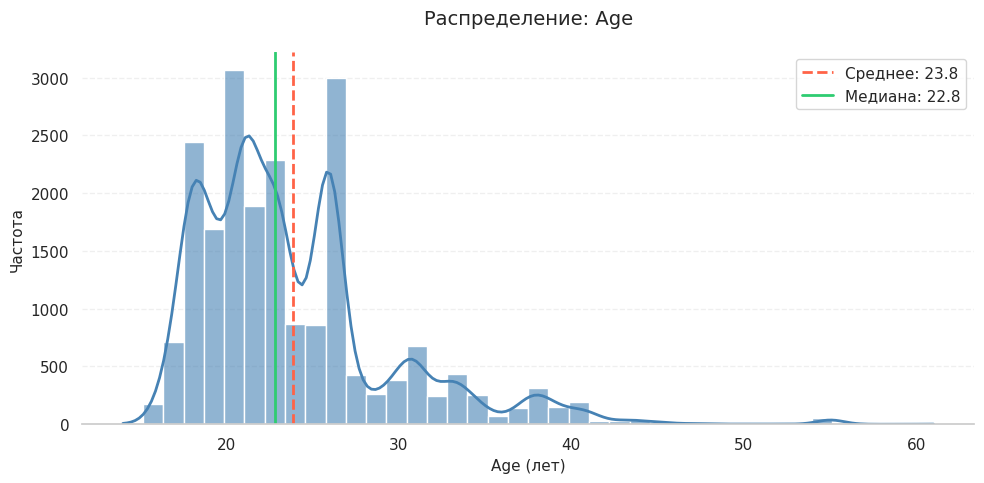

In [335]:
plot_numerical_distribution(df, 'Age', 'лет')

Вывод по распределению признака «Возраст» (Age)

* **Центральные тенденции:** Средний возраст исследуемых составляет **23.8 года**, медиана — **22.8 года**. Незначительная разница между ними указывает на то, что основная масса данных сосредоточена в молодом возрасте.
* **Вариативность и охват:** Данные охватывают диапазон от **14 до 61 года**. Стандартное отклонение (**5.7 лет**) говорит об умеренном разбросе значений относительно центра.
* **Форма распределения:** Коэффициент асимметрии (**Skewness = 1.6**) подтверждает правосторонний скос распределения — в выборке преобладают молодые люди, а «хвост» распределения уходит в сторону старшего возраста. Эксцесс (**Kurtosis = 3.7**) указывает на островершинность распределения (высокая концентрация данных вокруг медианы).
* **Выбросы:** Выявлено **1074 наблюдения**, выходящих за верхнюю границу в **35 лет**. Эти значения не являются ошибками ввода, а представляют группу лиц старшего возраста, которая в данном контексте считается статистически специфичной для общей «молодой» выборки.
* **Качество данных:** Пропуски отсутствуют, данные валидны и готовы к дальнейшему анализу.

In [336]:
print("АНАЛИЗ ВОЗРАСТА ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'Age'))

АНАЛИЗ ВОЗРАСТА ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Insufficient_Weight,2523,19.3,19.0,2.2,16.0,43.2
Normal_Weight,3082,20.8,21.0,3.4,14.0,51.0
Overweight_Level_I,2427,23.0,21.0,5.9,15.0,61.0
Obesity_Type_I,2910,25.0,22.9,7.2,14.0,55.0
Overweight_Level_II,2522,26.0,23.0,7.8,16.8,56.0
Obesity_Type_III,4046,24.1,26.0,2.6,18.0,30.6
Obesity_Type_II,3248,27.7,26.7,4.3,17.0,53.8


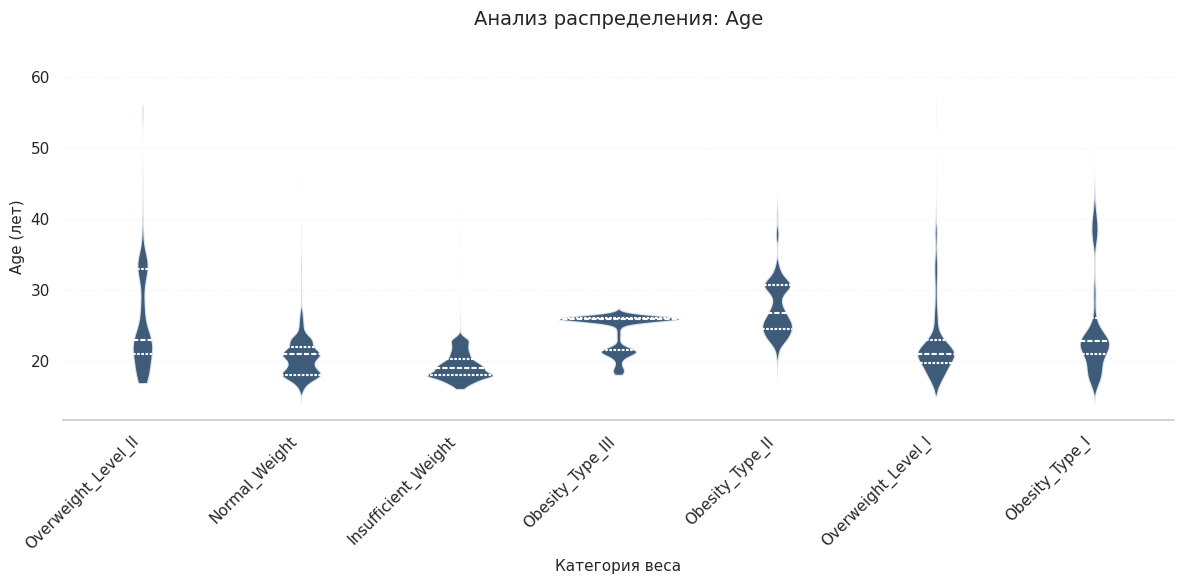

In [337]:
plot_feature_by_target_dark(df, 'Age', 'лет')

**Вывод по распределению возраста в разрезе категорий веса**

* **Возрастной градиент:** Наблюдается отчетливая тенденция к увеличению возраста при переходе от дефицита веса к более тяжелым степеням ожирения. Самая «молодая» группа — `Insufficient_Weight` (медиана **19 лет**), в то время как наиболее возрастные группы — `Obesity_Type_II` и `Obesity_Type_III` (медиана **26–26.7 лет**).
* **Концентрация данных:** Группа `Obesity_Type_III` является самой многочисленной (**4046 чел.**) и наиболее однородной по возрасту (самый низкий разброс `Std = 2.6` и узкий диапазон от **18 до 30.6 лет**). Это указывает на то, что данная степень ожирения в выборке характерна для конкретной молодой возрастной группы.
* **Вариативность (Разброс):** Наибольший разброс по возрасту наблюдается в категориях `Overweight_Level_II` и `Obesity_Type_I` (`Std` **7.2–7.8**). Это говорит о том, что избыточный вес данных уровней встречается в самом широком возрастном диапазоне — от подростков до людей старше 55 лет.
* **Аномалии (Экстремумы):** Группа `Overweight_Level_I` содержит самое возрастное наблюдение в датасете (**61 год**), в то время как нормальный вес и дефицит массы тела чаще встречаются у лиц до 21 года.

##**2. Анализ признака вес**

In [338]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ВЕС")
weight_stats = get_numerical_summary(df, 'Weight', 'кг')
display(weight_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ВЕС


,Метрика,Значение (кг)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),87.9
4,Медиана (Median),84.1
5,Стандартное отклонение,26.4
6,Дисперсия,695.9
7,Минимум,39.0
8,Максимум,165.1
9,Скошенность (Skewness),0.1


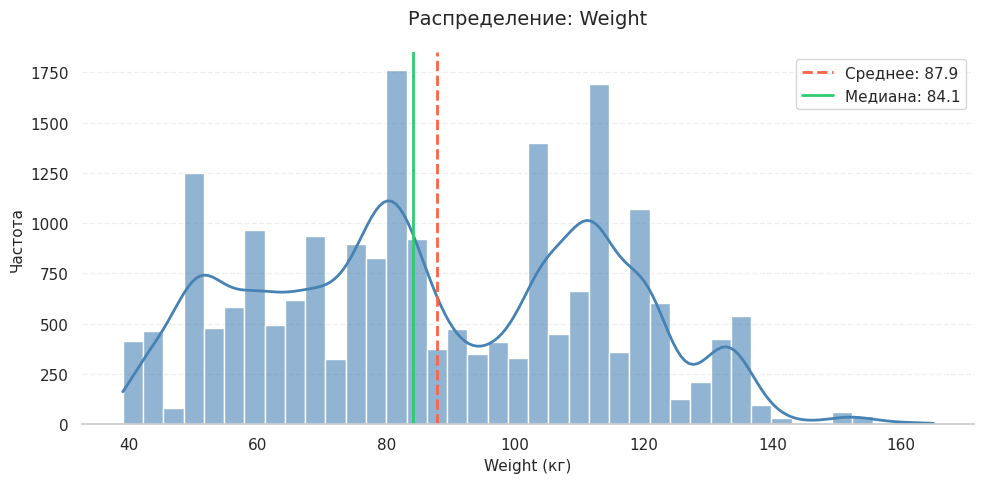

In [339]:
plot_numerical_distribution(df, 'Weight', 'кг')

**Вывод по распределению признака «Вес» (Weight)**

* **Центральные показатели:** Средний вес участников составляет **87.9 кг**, при этом медиана ниже — **84.1 кг**. Это указывает на наличие группы респондентов с очень высоким весом, которые смещают среднее значение в большую сторону.
* **Вариативность:** Наблюдается значительный разброс данных: стандартное отклонение составляет **26.4 кг**, а разница между минимальным (**39 кг**) и максимальным (**165.1 кг**) значениями достигает **126 кг**. Это подтверждает присутствие в выборке всех типов телосложения — от выраженного дефицита массы до тяжелых степеней ожирения.
* **Форма распределения:** * **Скошенность (Skewness = 0.1):** Распределение почти симметрично, что нетипично для биологических данных и часто указывает на синтетическую природу датасета или очень сбалансированную выборку.
* **Эксцесс (Kurtosis = -1.0):** Отрицательное значение указывает на «плосковершинность» распределения. Это означает, что данные не концентрируются вокруг одного пика, а распределены более равномерно по разным весовым категориям.
* **Выбросы:** Статистические выбросы по методу межквартильного размаха **отсутствуют** (0.0). Все значения, включая экстремальные 165 кг, укладываются в расчетные границы (верхняя граница — 180 кг) и являются допустимыми для данного исследования.
* **Качество данных:** Данные полные (пропусков 0%), аномалий, требующих удаления, не обнаружено.

In [340]:
print("АНАЛИЗ ВЕСА ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'Weight'))

АНАЛИЗ ВЕСА ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Insufficient_Weight,2523,49.9,50.0,5.7,39.0,113.7
Normal_Weight,3082,61.5,60.0,8.5,41.9,90.0
Overweight_Level_I,2427,74.2,75.0,8.0,42.0,96.7
Overweight_Level_II,2522,82.1,81.6,7.4,55.0,115.0
Obesity_Type_I,2910,92.4,90.1,11.4,40.2,155.9
Obesity_Type_III,4046,117.7,111.9,13.3,42.0,165.1
Obesity_Type_II,3248,116.0,118.3,7.8,76.2,137.8


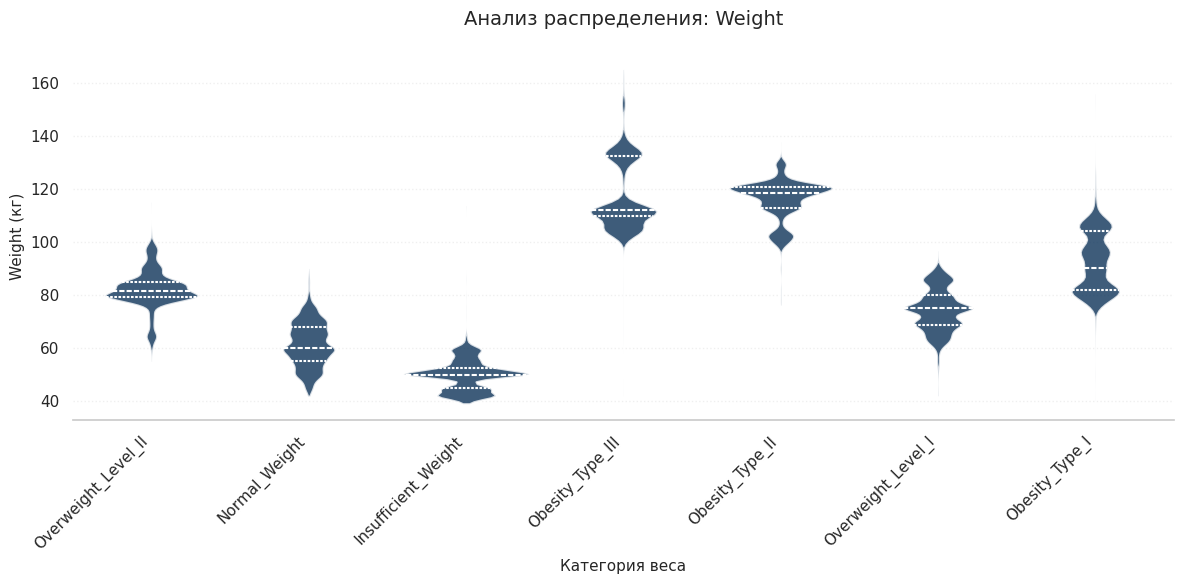

In [341]:
plot_feature_by_target_dark(df, 'Weight', 'кг')

**Вывод по распределению веса внутри категорий ожирения**

* **Линейный рост и иерархия:** Наблюдается четкий и последовательный рост медианного веса при переходе от категории к категории: от минимальных **50 кг** (`Insufficient_Weight`) до пиковых **118.3 кг** (`Obesity_Type_II`). Это подтверждает, что вес является определяющим фактором в классификации данного датасета.
* **Группы экстремальных значений:** Категории `Obesity_Type_II` и `Obesity_Type_III` демонстрируют самые высокие показатели среднего веса (**~116–117 кг**). При этом в `Obesity_Type_III` зафиксирован абсолютный максимум — **165.1 кг**.
* **Вариативность и «размытые» границы:** Самый высокий разброс (`Std = 13.3`) наблюдается в группе `Obesity_Type_III`, что говорит о большой разнице в весе внутри этой категории. Также стоит отметить аномально низкие минимальные значения в некоторых тяжелых категориях (например, **40.2 кг** в `Obesity_Type_I` и **42.0 кг** в `Obesity_Type_III`), что может свидетельствовать о влиянии роста на расчет индекса массы тела (ИМТ).
* **Пересечение категорий:** Значительное совпадение диапазонов (Min/Max) между `Overweight_Level_II` и `Obesity_Type_I` указывает на то, что при одинаковом весе люди могут попадать в разные категории в зависимости от роста и других параметров.

##**3. Анали признака рост**

In [342]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: РОСТ")
height_stats = get_numerical_summary(df, 'Height', 'м')
display(height_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: РОСТ


,Метрика,Значение (м)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),1.7
4,Медиана (Median),1.7
5,Стандартное отклонение,0.1
6,Дисперсия,0.0
7,Минимум,1.4
8,Максимум,2.0
9,Скошенность (Skewness),0.0


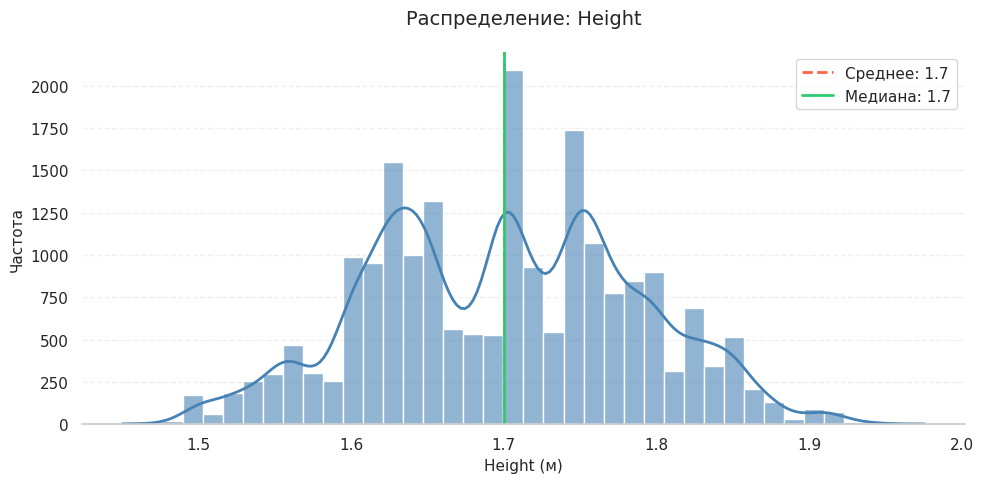

In [343]:
plot_numerical_distribution(df, 'Height', 'м')

**Вывод по распределению признака «Рост» (Height)**

* **Идеальная симметрия:** Среднее (**1.70 м**) и медиана (**1.70 м**) полностью совпадают, а коэффициент скошенности практически равен нулю (**Skewness = 0.0**). Это указывает на идеально симметричное, классическое нормальное распределение признака в выборке.
* **Антропометрические границы:** Рост респондентов варьируется в естественном диапазоне от **1.45 м** до **1.98 м**. Стандартное отклонение (**0.09 м**) показывает, что большинство людей в выборке имеют рост в пределах 1.61–1.79 м.
* **Форма распределения (Kurtosis = -0.6):** Отрицательный эксцесс говорит о том, что распределение чуть более «плоское», чем эталонное нормальное. Это означает, что в данных нет резкого преобладания людей только среднего роста, выборка достаточно разнообразна.
* **Отсутствие аномалий:** Выявлено всего **4 выброса**, которые фактически находятся на расчетных границах (1.45 м и 1.98 м). Это реальные значения роста, не являющиеся ошибками измерения.
* **Качество данных:** Признак не имеет пропусков и представляет собой качественную основу для расчета ИМТ (BMI).

In [344]:
print("АНАЛИЗ РОСТА ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'Height'))

АНАЛИЗ РОСТА ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Obesity_Type_III,4046,1.7,1.6,0.1,1.5,1.9
Insufficient_Weight,2523,1.7,1.7,0.1,1.5,2.0
Obesity_Type_I,2910,1.7,1.7,0.1,1.5,2.0
Normal_Weight,3082,1.7,1.7,0.1,1.4,1.9
Overweight_Level_II,2522,1.7,1.7,0.1,1.5,1.9
Overweight_Level_I,2427,1.7,1.7,0.1,1.4,1.9
Obesity_Type_II,3248,1.8,1.8,0.1,1.5,2.0


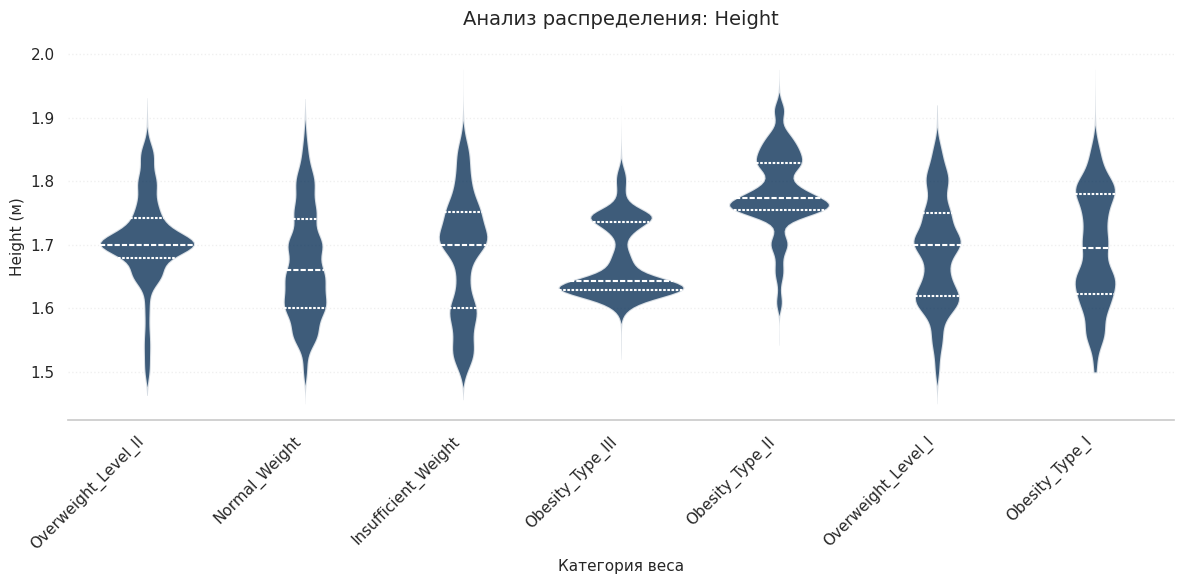

In [345]:
plot_feature_by_target_dark(df, 'Height', 'м')

**Вывод по распределению роста по категориям веса**

* **Стабильность показателя:** Рост является самым стабильным признаком во всей выборке. Среднее и медиана почти во всех категориях зафиксированы на уровне **1.70 м**, что говорит о том, что риск ожирения в данном датасете распределен равномерно среди людей разного роста.
* **Исключение для Obesity_Type_II:** Группа `Obesity_Type_II` (Ожирение 2 типа) выделяется на общем фоне — её медианный рост выше и составляет **1.80 м**. Это указывает на то, что в данной конкретной подгруппе преобладают более высокие респонденты.
* **Особенности Obesity_Type_III:** Самая тяжелая категория ожирения имеет самую низкую медиану роста — **1.60 м**. Это объясняет, почему при сопоставимом весе с другими группами (`~117 кг`), ИМТ в этой категории выше: избыточная масса распределена на меньший рост.
* **Однородность разброса:** Стандартное отклонение во всех группах идентично (**0.1 м**), а диапазоны (от **1.4–1.5 м** до **1.9–2.0 м**) практически дублируют друг друга. Это подтверждает отсутствие специфических аномалий роста внутри отдельных типов веса.

##**4. Анализ признака физическая активность (FAF)**

In [346]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ФИЗИЧЕСКАЯ АКТИВНОСТЬ")
faf_stats = get_numerical_summary(df, 'FAF', 'индекс')
display(faf_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ФИЗИЧЕСКАЯ АКТИВНОСТЬ


,Метрика,Значение (индекс)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),1.0
4,Медиана (Median),1.0
5,Стандартное отклонение,0.8
6,Дисперсия,0.7
7,Минимум,0.0
8,Максимум,3.0
9,Скошенность (Skewness),0.5


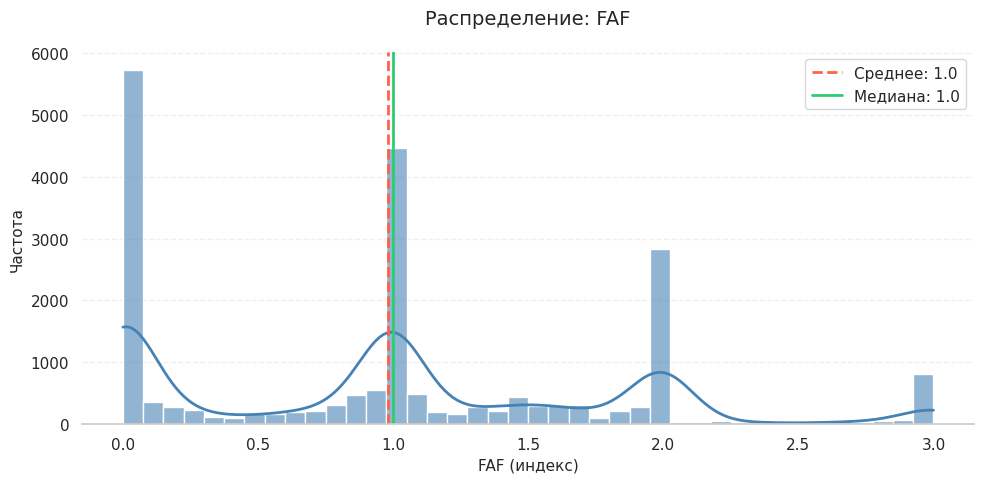

In [347]:
plot_numerical_distribution(df, 'FAF', 'индекс')

**Вывод по распределению признака «Физическая активность» (FAF)**

* **Низкий уровень активности:** Среднее значение (**1.0**) и медиана (**1.0**) указывают на то, что типичный респондент уделяет время физическим нагрузкам лишь 1–2 раза в неделю. Это свидетельствует о преобладании малоподвижного образа жизни в общей выборке.
* **Диапазон и вариативность:** Показатели варьируются от **0.0** (полное отсутствие активности) до **3.0** (высокая активность). Стандартное отклонение (**0.8**) говорит о том, что большинство ответов сосредоточено в узком диапазоне между «почти никогда» и «иногда».
* **Форма распределения:** * **Скошенность (Skewness = 0.5):** Положительный коэффициент подтверждает правосторонний скос — большая часть данных сконцентрирована в левой части графика (низкие значения), а «хвост» из активных людей значительно меньше.
* **Эксцесс (Kurtosis = -0.5):** Отрицательный эксцесс указывает на плосковершинность, что говорит об отсутствии одного доминирующего типа поведения: респонденты распределены по всем уровням активности достаточно равномерно, без явного пика.
* **Отсутствие выбросов:** Все значения укладываются в логические границы индекса (0–3), аномальных данных не обнаружено. Данные готовы для корреляционного анализа с категориями веса.

In [348]:
print("АНАЛИЗ FAF ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'FAF'))

АНАЛИЗ FAF ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Obesity_Type_III,4046,0.5,0.0,0.7,0.0,2.9
Insufficient_Weight,2523,1.2,1.0,0.8,0.0,3.0
Obesity_Type_I,2910,0.9,1.0,0.9,0.0,3.0
Normal_Weight,3082,1.2,1.0,0.9,0.0,3.0
Obesity_Type_II,3248,1.0,1.0,0.5,0.0,3.0
Overweight_Level_I,2427,1.1,1.0,0.9,0.0,3.0
Overweight_Level_II,2522,1.1,1.0,0.8,0.0,3.0


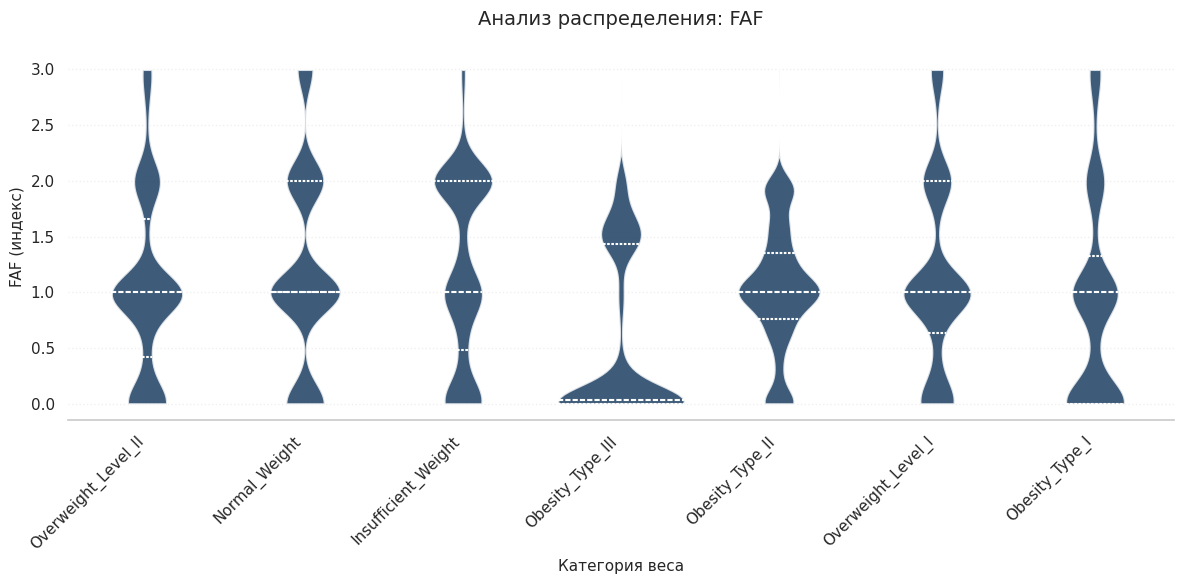

In [349]:
plot_feature_by_target_dark(df, 'FAF', 'индекс')

**Вывод по физической активности (FAF) в разрезе категорий веса**

* **Критический дефицит активности в Obesity_Type_III:** Категория с самым тяжелым ожирением демонстрирует минимальные показатели: среднее **0.5**, а медиана равна **0.0**. Это означает, что более половины респондентов в этой группе ведут абсолютно неподвижный образ жизни.
* **Стабильность в остальных группах:** Интересно, что во всех остальных категориях (от дефицита веса до ожирения II типа) медиана активности неизменна и составляет **1.0**. Это говорит о том, что умеренная активность сама по себе не является единственным разграничителем между этими типами веса.
* **Однородность группы Obesity_Type_II:** Эта категория имеет самый низкий разброс (`Std = 0.5`), что указывает на крайне схожее поведение всех участников группы — стабильно низкий уровень нагрузки.
* **Потенциал «здоровых» привычек:** Во всех группах, включая ожирение, максимальное значение достигает **3.0**. Это подтверждает наличие активных людей даже в категориях с высоким ИМТ, что может быть важным фактором для анализа «метаболически здорового ожирения».

##**5. Анализ признака потребление овощенй (FCVC)**

In [350]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ПОТРЕБЛЕНИЕ ОВОЩЕЙ")
fcvc_stats = get_numerical_summary(df, 'FCVC', 'индекс')
display(fcvc_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ПОТРЕБЛЕНИЕ ОВОЩЕЙ


,Метрика,Значение (индекс)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),2.4
4,Медиана (Median),2.4
5,Стандартное отклонение,0.5
6,Дисперсия,0.3
7,Минимум,1.0
8,Максимум,3.0
9,Скошенность (Skewness),-0.4


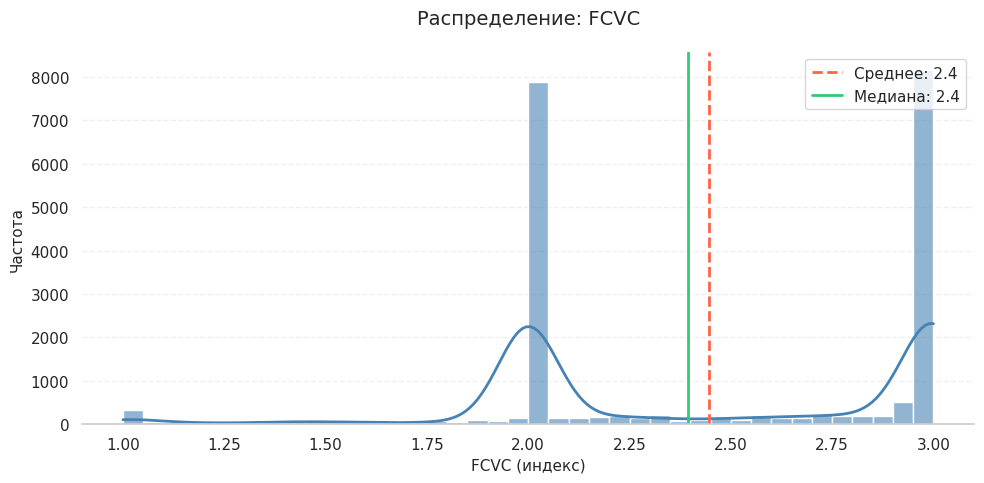

In [351]:
plot_numerical_distribution(df, 'FCVC', 'индекс')

**Вывод по распределению признака «Потребление овощей» (FCVC)**

* **Высокий средний уровень:** Среднее значение (**2.4**) и медиана (**2.4**) смещены к верхней границе индекса (3.0). Это говорит о том, что большая часть респондентов в выборке заявляет о регулярном включении овощей в свой рацион.
* **Смещение в сторону здоровых привычек (Skewness = -0.4):** Отрицательный коэффициент скошенности подтверждает левосторонний скос — основная масса данных сосредоточена в зоне высоких значений (2–3), в то время как людей, почти не употребляющих овощи (индекс 1), значительно меньше.
* **Отсутствие доминирующего пика (Kurtosis = -0.9):** Отрицательный эксцесс указывает на то, что распределение довольно равномерное («плоское») в интервале от 2 до 3. Это значит, что в выборке нет одной преобладающей группы, и ответы распределены по всему спектру средних и высоких значений.
* **Стабильность данных:** Низкое стандартное отклонение (**0.5**) и полное отсутствие выбросов свидетельствуют о высокой однородности ответов. Значения строго ограничены логическим диапазоном от 1 до 3.

In [352]:
print("АНАЛИЗ FCVC ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'FCVC'))

АНАЛИЗ FCVC ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Normal_Weight,3082,2.4,2.0,0.5,1.0,3.0
Obesity_Type_I,2910,2.1,2.0,0.4,1.0,3.0
Overweight_Level_II,2522,2.2,2.0,0.4,1.0,3.0
Overweight_Level_I,2427,2.3,2.0,0.5,1.0,3.0
Obesity_Type_II,3248,2.4,2.5,0.5,1.0,3.0
Insufficient_Weight,2523,2.5,2.8,0.6,1.0,3.0
Obesity_Type_III,4046,3.0,3.0,0.0,3.0,3.0


**Вывод по потреблению овощей (FCVC) по категориям веса**

* **Аномалия Obesity_Type_III:** Эта группа демонстрирует уникальное поведение: среднее и медиана равны **3.0** при нулевом стандартном отклонении (**Std = 0.0**). Все 4046 человек в этой категории указали максимальное потребление овощей.
* **Градиент потребления:** Самое низкое потребление овощей наблюдается в группах `Obesity_Type_I` и `Overweight_Level_II` (медиана **2.0**).
* **Связь с недостаточным весом:** Высокий показатель медианы (**2.8**) у группы `Insufficient_Weight` подтверждает связь между высоким потреблением растительной пищи и низким ИМТ.
* **Однородность групп:** Большинство категорий имеют схожий разброс (Std 0.4–0.6), за исключением тяжелого ожирения, где данные абсолютно идентичны.

##**6. Анализ признака количество приемов пищи (NCP)**

In [353]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: КОЛИЧЕСТВО ПРИЕМОВ ПИЩИ")
ncp_stats = get_numerical_summary(df, 'NCP', 'кол-во')
display(ncp_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: КОЛИЧЕСТВО ПРИЕМОВ ПИЩИ


,Метрика,Значение (кол-во)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),2.8
4,Медиана (Median),3.0
5,Стандартное отклонение,0.7
6,Дисперсия,0.5
7,Минимум,1.0
8,Максимум,4.0
9,Скошенность (Skewness),-1.6


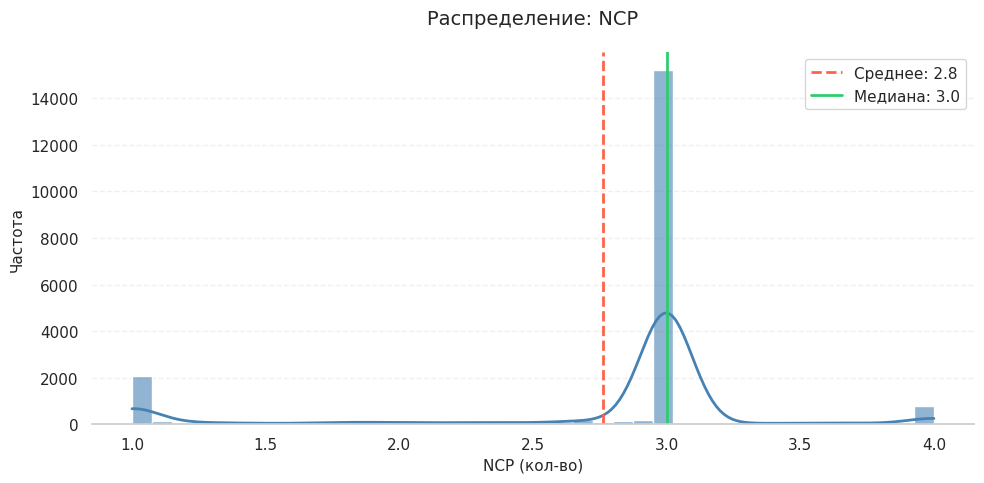

In [354]:
plot_numerical_distribution(df, 'NCP', 'кол-во')

**Вывод по распределению признака «Количество приемов пищи» (NCP)**

* **Доминирующий стандарт:** Медиана (**3.0**) и среднее (**2.8**) указывают на то, что подавляющее большинство респондентов придерживаются классической схемы трехразового питания.
* **Сильный левосторонний скос (Skewness = -1.6):** Коэффициент скошенности говорит о том, что основная масса данных сосредоточена в районе 3–4 приемов пищи, в то время как «хвост» распределения уходит в сторону тех, кто ест редко (1–2 раза).
* **Высокая концентрация и островершинность (Kurtosis = 1.8):** Положительный эксцесс подтверждает, что распределение имеет острый пик в районе значения 3.0. Это «стандартное» поведение для данной выборки.
* **Статистическая аномалия с выбросами:** Программа зафиксировала огромное количество выбросов (**6052**), так как границы (Нижняя и Верхняя) схлопнулись на значении **3.0**. Это происходит потому, что межквартильный размах равен нулю (большинство ответов идентичны). С точки зрения медицины это не аномалии, а просто люди, чей режим питания отличается от самого массового значения (те, кто ест 1, 2 или 4 раза в день).

In [355]:
print("АНАЛИЗ NCP ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'NCP'))

АНАЛИЗ NCP ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Insufficient_Weight,2523,2.9,3.0,0.9,1.0,4.0
Normal_Weight,3082,2.9,3.0,0.7,1.0,4.0
Obesity_Type_I,2910,2.5,3.0,0.8,1.0,4.0
Obesity_Type_II,3248,2.8,3.0,0.5,1.0,4.0
Obesity_Type_III,4046,3.0,3.0,0.0,2.8,3.0
Overweight_Level_I,2427,2.5,3.0,0.9,1.0,4.0
Overweight_Level_II,2522,2.6,3.0,0.7,1.0,4.0


**Вывод по количеству приемов пищи (NCP) в разрезе категорий веса**

* **Тотальное доминирование трехразового питания:** Медиана во **всех без исключения** категориях равна **3.0**. Это показывает, что традиционный режим питания (завтрак, обед, ужин) является фундаментальным стандартом поведения для всей выборки, независимо от индекса массы тела.
* **Аномальная стабильность в Obesity_Type_III:** Как и в случае с овощами (FCVC), группа с самым тяжелым ожирением демонстрирует почти нулевую вариативность (`Std = 0.0` при округлении, диапазон всего **2.8–3.0**). Все 4046 человек в этой группе питаются строго трижды в день, что выглядит как статистическая особенность данного набора данных.
* **Склонность к дефициту приемов пищи:** Категории `Obesity_Type_I` и `Overweight_Level_I` имеют самые низкие средние значения (**2.5**). Это говорит о том, что в группах с начальным ожирением и избыточным весом чаще встречаются люди, пропускающие приемы пищи (питающиеся 1–2 раза в день), чем в группах с нормальным весом.
* **Разнообразие режимов:** Группы `Insufficient_Weight` и `Normal_Weight` имеют самый высокий разброс и среднее (**2.9**), а также чаще включают людей, питающихся 4 раза в день, что может указывать на более дробное и регулярное питание у людей без лишнего веса.

##**7. Анализ признака потребления воды (CH2O)**

In [356]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ПОТРЕБЛЕНИЕ ВОДЫ")
water_stats = get_numerical_summary(df, 'CH2O', 'л')
display(water_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ПОТРЕБЛЕНИЕ ВОДЫ


,Метрика,Значение (л)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),2.0
4,Медиана (Median),2.0
5,Стандартное отклонение,0.6
6,Дисперсия,0.4
7,Минимум,1.0
8,Максимум,3.0
9,Скошенность (Skewness),-0.2


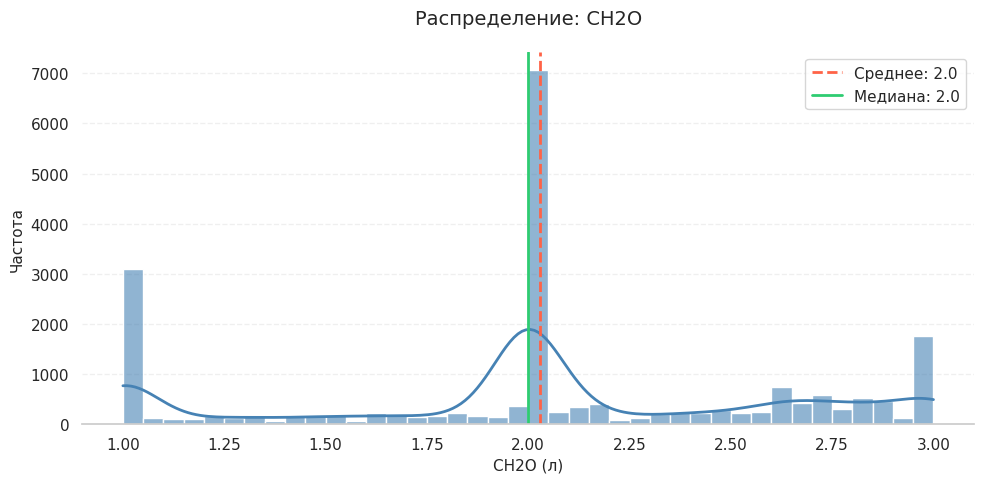

In [357]:
plot_numerical_distribution(df, 'CH2O', 'л')

**Вывод по распределению признака «Потребление воды» (CH2O)**

* **Оптимальный средний уровень:** Среднее значение и медиана полностью совпадают (**2.0 л**). Это говорит о том, что центральный респондент в выборке соблюдает общепринятую норму потребления жидкости.
* **Сбалансированность выборки (Skewness = -0.2):** Коэффициент скошенности близок к нулю с легким уклоном в сторону большего потребления. Распределение практически симметрично: количество людей, пьющих мало воды (1 л), уравновешено теми, кто пьет много (3 л).
* **Равномерное распределение (Kurtosis = -0.7):** Отрицательный эксцесс указывает на отсутствие резкого пика. Ответы распределены по всему диапазону (1, 2 и 3 литра) достаточно широко, что характерно для разнообразной выборки.
* **Чистота данных:** Стандартное отклонение составляет **0.6 л**, что при отсутствии выбросов подтверждает компактность и реалистичность данных. Минимальные (**1.0**) и максимальные (**3.0**) значения находятся в пределах физиологической нормы.

In [358]:
print("АНАЛИЗ CH2O ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'CH2O'))

АНАЛИЗ CH2O ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Insufficient_Weight,2523,1.7,2.0,0.6,1.0,3.0
Normal_Weight,3082,1.8,2.0,0.6,1.0,3.0
Obesity_Type_I,2910,2.1,2.0,0.6,1.0,3.0
Obesity_Type_II,3248,2.0,2.0,0.6,1.0,3.0
Overweight_Level_I,2427,2.1,2.0,0.6,1.0,3.0
Overweight_Level_II,2522,2.0,2.0,0.5,1.0,3.0
Obesity_Type_III,4046,2.3,2.6,0.6,1.0,3.0


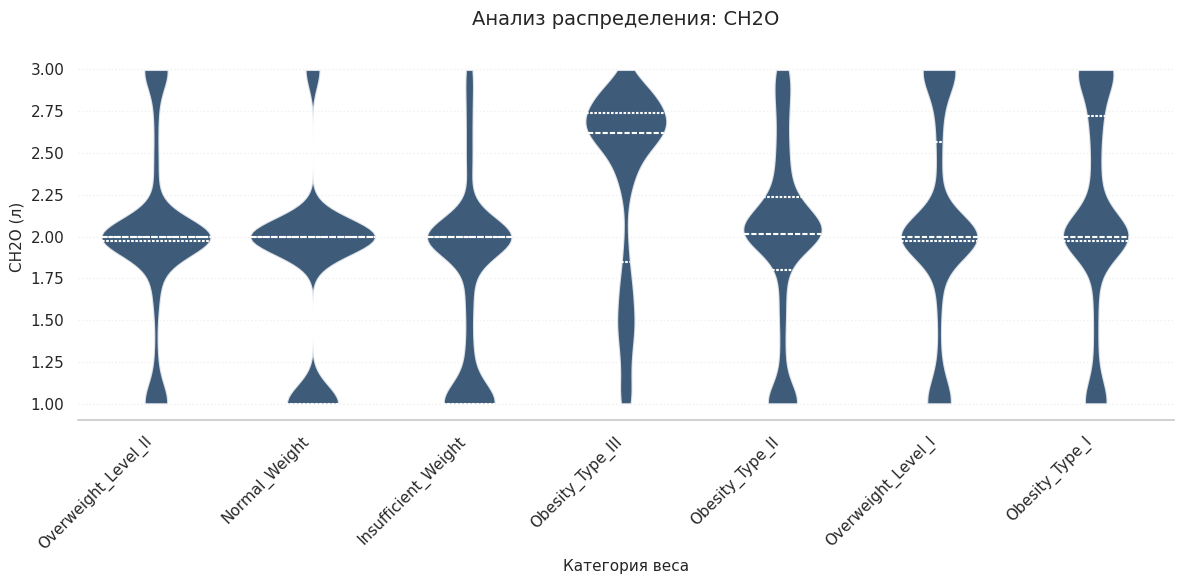

In [359]:
plot_feature_by_target_dark(df, 'CH2O', 'л')

**Вывод по потреблению воды (CH2O) по категориям веса**

* **Единообразие привычек:** Медиана потребления воды почти во всех группах (от дефицита веса до ожирения II типа) стабильна и составляет **2.0 литра**. Это указывает на отсутствие прямой линейной зависимости между гидратацией и категорией веса для большинства участников.
* **Повышенное потребление в Obesity_Type_III:** Группа с самым тяжелым ожирением выделяется наиболее высокими показателями: среднее **2.3 л** и медиана **2.6 л**. Это может быть связано с более высокими физиологическими потребностями организма в воде при большой массе тела.
* **Минимальные показатели у групп с низким весом:** Самые низкие средние значения зафиксированы в категориях `Insufficient_Weight` (**1.7 л**) и `Normal_Weight` (**1.8 л**), что также коррелирует с меньшей массой тела и меньшим объемом необходимых энергозатрат.
* **Высокая стабильность данных:** Стандартное отклонение во всех группах практически идентично (**0.5–0.6**), что говорит о схожем разбросе привычек питьевого режима внутри каждой категории.

##**8. Анализ признака время за гаджетами (TUE)**

In [360]:
print("СТАТИСТИЧЕСКАЯ СВОДКА: ВРЕМЯ ПЕРЕД ЭКРАНОМ")
tue_stats = get_numerical_summary(df, 'TUE', 'индекс')
display(tue_stats)

СТАТИСТИЧЕСКАЯ СВОДКА: ВРЕМЯ ПЕРЕД ЭКРАНОМ


,Метрика,Значение (индекс)
0,Общее количество,20758.0
1,Пропущенные значения,0.0
2,Процент пропусков (%),0.0
3,Среднее (Mean),0.6
4,Медиана (Median),0.6
5,Стандартное отклонение,0.6
6,Дисперсия,0.4
7,Минимум,0.0
8,Максимум,2.0
9,Скошенность (Skewness),0.7


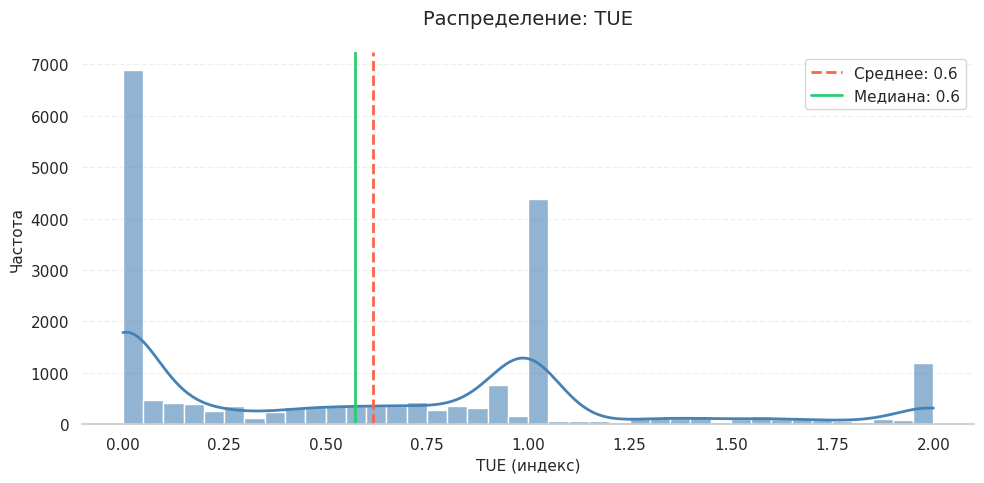

In [361]:
plot_numerical_distribution(df, 'TUE', 'индекс')

**Вывод по распределению признака «Время перед экраном» (TUE)**

* **Низкий средний уровень:** Среднее значение (**0.6**) и медиана (**0.6**) находятся в нижней части шкалы (0–2). Это говорит о том, что в среднем респонденты тратят умеренное количество времени на гаджеты и телевизор.
* **Правосторонний скос (Skewness = 0.7):** Положительная скошенность указывает на то, что большинство людей имеют низкий индекс использования технологий, а группа «активных пользователей» (с индексом ближе к 2.0) значительно меньше.
* **Равномерность распределения (Kurtosis = -0.4):** Отрицательный эксцесс свидетельствует о том, что данные распределены достаточно «плоско» по доступному диапазону. Нет одного ярко выраженного пика, мнения респондентов разделились.
* **Отсутствие аномалий:** Все данные находятся в пределах допустимого диапазона (**0.0 – 2.0**), выбросы отсутствуют. Это делает признак надежным для дальнейшего анализа взаимосвязи с физической активностью.

In [362]:
print("АНАЛИЗ TUE ПО КАТЕГОРИЯМ ВЕСА")
display(get_feature_target_pivot(df, 'TUE'))

АНАЛИЗ TUE ПО КАТЕГОРИЯМ ВЕСА


,Кол-во,Среднее,Медиана,Std,Мин,Макс
NObeyesdad,,,,,,
Obesity_Type_II,3248,0.4,0.1,0.5,0.0,2.0
Overweight_Level_I,2427,0.6,0.1,0.7,0.0,2.0
Obesity_Type_III,4046,0.5,0.6,0.3,0.0,2.0
Obesity_Type_I,2910,0.7,0.7,0.7,0.0,2.0
Overweight_Level_II,2522,0.7,0.9,0.6,0.0,2.0
Normal_Weight,3082,0.6,1.0,0.6,0.0,2.0
Insufficient_Weight,2523,0.8,1.0,0.7,0.0,2.0


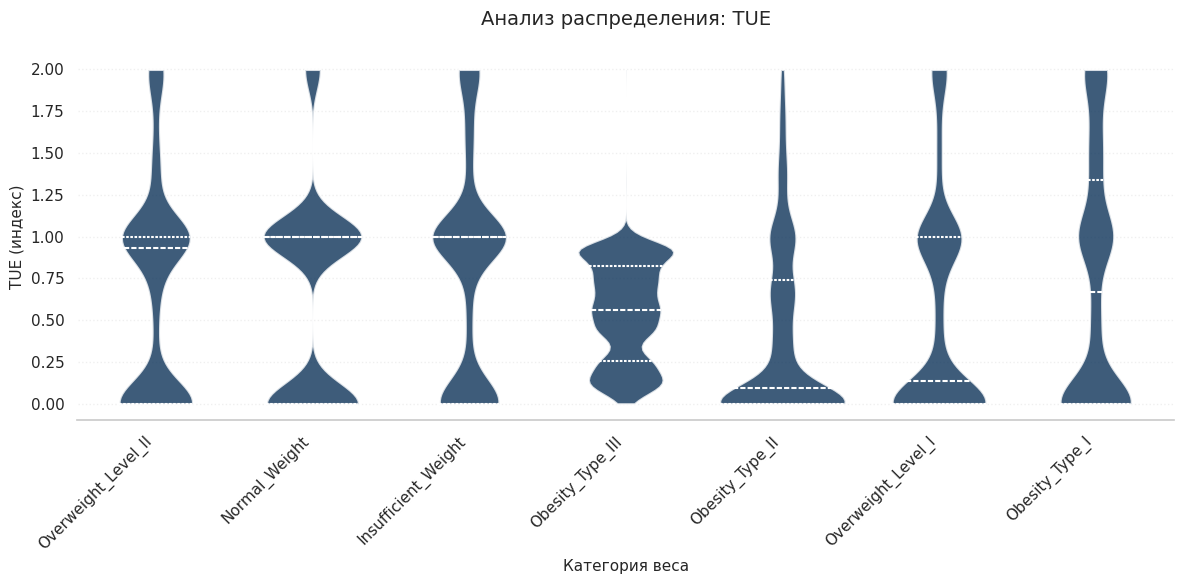

In [363]:
plot_feature_by_target_dark(df, 'TUE', 'индекс')

**Вывод по времени перед экраном (TUE) по категориям веса**

* **Обратная зависимость:** Наблюдается интересная тенденция — медианное время перед экраном **выше** у групп с более низким весом. У категорий `Normal_Weight` и `Insufficient_Weight` медиана составляет **1.0**, в то время как у самых тяжелых категорий ожирения она значительно ниже.
* **Минимум у Obesity_Type_II:** Группа с ожирением II типа демонстрирует самый низкий показатель использования технологий (медиана **0.1**). Это может указывать на то, что для данной группы гаджеты не являются основным фактором сидячего образа жизни.
* **Специфика Obesity_Type_III:** У самой тяжелой категории ожирения медиана составляет **0.6**, а разброс самый низкий (`Std = 0.3`). Это говорит о большой однородности группы: почти все респонденты проводят за экраном умеренное, стабильно среднее количество времени.
* **Разрыв в привычках:** Группы `Overweight_Level_II` и `Normal_Weight` имеют медианы **0.9** и **1.0** соответственно, что свидетельствует о том, что цифровой досуг более характерен для людей с умеренным или нормальным весом в данном датасете.

---

**Итог по блоку «Образ жизни»**

1. **Физическая активность (FAF):** Падает до нуля при тяжелом ожирении.
2. **Овощи (FCVC) и Питание (NCP):** Показывают аномально «правильные» значения у группы Obesity III.
3. **Вода (CH2O):** Потребление растет вместе с массой тела.
4. **Гаджеты (TUE):** Парадоксально выше у людей с нормальным и низким весом.


#**Анализ категориальных признаков датасета**

##**1. Анализ распределения бинарных признаков**

In [364]:
BINARY_FEAT = ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']
BIN_TRANS = {'Gender': 'Пол', 'family_history_with_overweight': 'Наследственность', 'FAVC': 'Калорийная еда', 'SMOKE': 'Курение', 'SCC': 'Контроль калорий'}

bin_data = []
for f in BINARY_FEAT:
    s = df[f].value_counts()
    for i, (val, count) in enumerate(s.items()):
        bin_data.append({'Признак': BIN_TRANS[f], 'Класс': val, 'Количество': count, 'Процент (%)': round(count/len(df)*100, 1),
                         'Мода': s.index[0] if i==0 else '', 'Дисбаланс': f"1:{round(s.max()/s.min(),1)}" if i==0 else ''})

display(HTML(custom_style + generate_styled_table(pd.DataFrame(bin_data), "БИНАРНЫЕ ПРИЗНАКИ")))


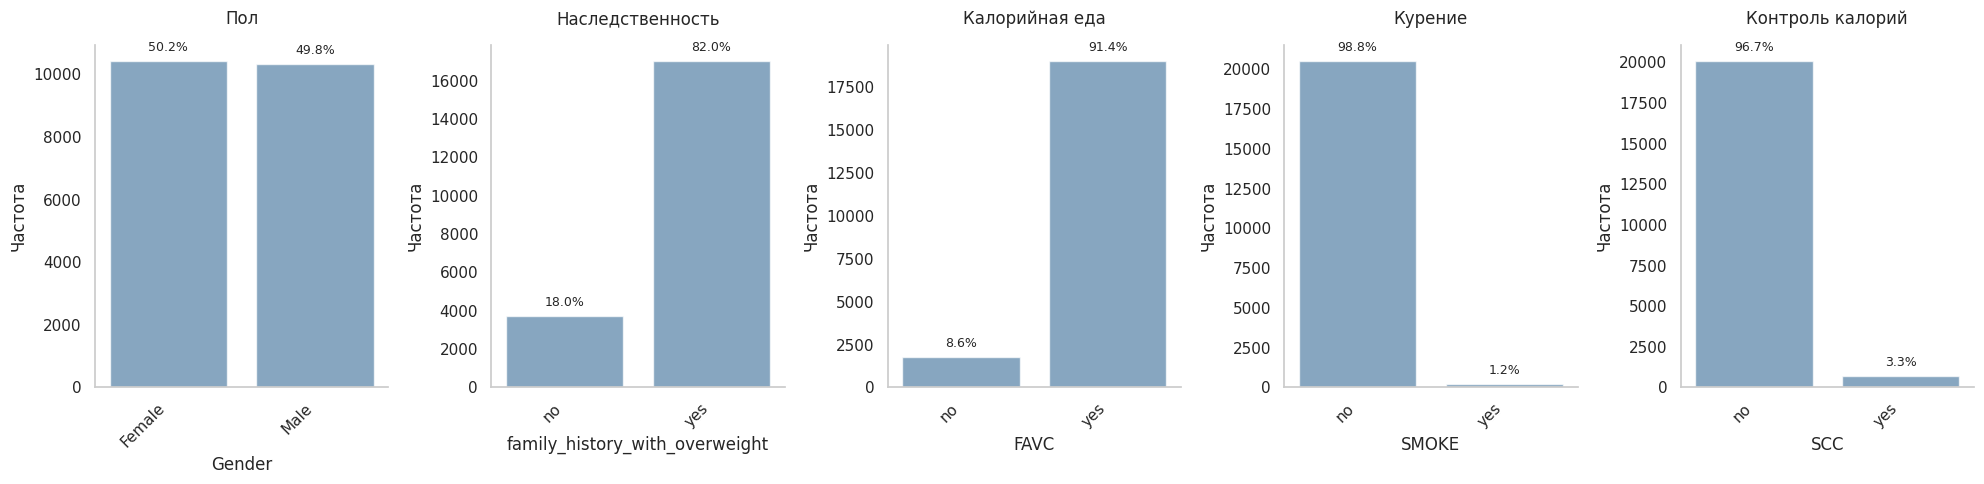

In [365]:
plot_categorical_grid(df, BINARY_FEAT, BIN_TRANS, colors='#4682B4')

Группа бинарных признаков демонстрирует как идеально сбалансированные показатели, так и переменные с экстремальным распределением:

* **Гендерный баланс:** Признак **«Пол»** распределен практически поровну (**50.2%** женщин против **49.8%** мужчин). Это гарантирует, что итоговая модель будет одинаково хорошо обучена на данных обоих полов без гендерного смещения.
* **Ключевые факторы риска:** Наблюдается высокая концентрация негативных факторов. **82%** респондентов имеют **наследственную предрасположенность** к лишнему весу, а **91.4%** регулярно употребляют **высококалорийную еду**. Эти признаки, вероятно, станут наиболее значимыми предикторами для определения степеней ожирения.
* **Низкая популярность здоровых привычек:** Признак **«Контроль калорий»** показал критически низкое значение — лишь **3.3%** участников следят за своим рационом. Дисбаланс **1:29.2** делает эту группу малочисленной, но потенциально важной для выявления категории «Нормальный вес».
* **Вредные привычки (Курение):** Подавляющее большинство респондентов (**98.8%**) не курят. Высокий дисбаланс (**1:83.7**) указывает на то, что фактор курения в данной выборке практически не влияет на общую вариативность данных и может иметь минимальный вес в итоговой модели.

###**Анализ признака пол (Gender)**

In [366]:
print("АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПЕРЕМЕННОЙ ПОЛ ПО КАТЕГОРИЯМ ВЕСА")
gender_target_pivot = pd.crosstab(df['NObeyesdad'], df['Gender'], normalize='index') * 100
display(gender_target_pivot.round(1))

АНАЛИЗ РАСПРЕДЕЛЕНИЯ ПЕРЕМЕННОЙ ПОЛ ПО КАТЕГОРИЯМ ВЕСА


Gender,Female,Male
NObeyesdad,,
Insufficient_Weight,64.2,35.8
Normal_Weight,53.9,46.1
Obesity_Type_I,43.5,56.5
Obesity_Type_II,0.2,99.8
Obesity_Type_III,99.9,0.1
Overweight_Level_I,44.1,55.9
Overweight_Level_II,29.9,70.1


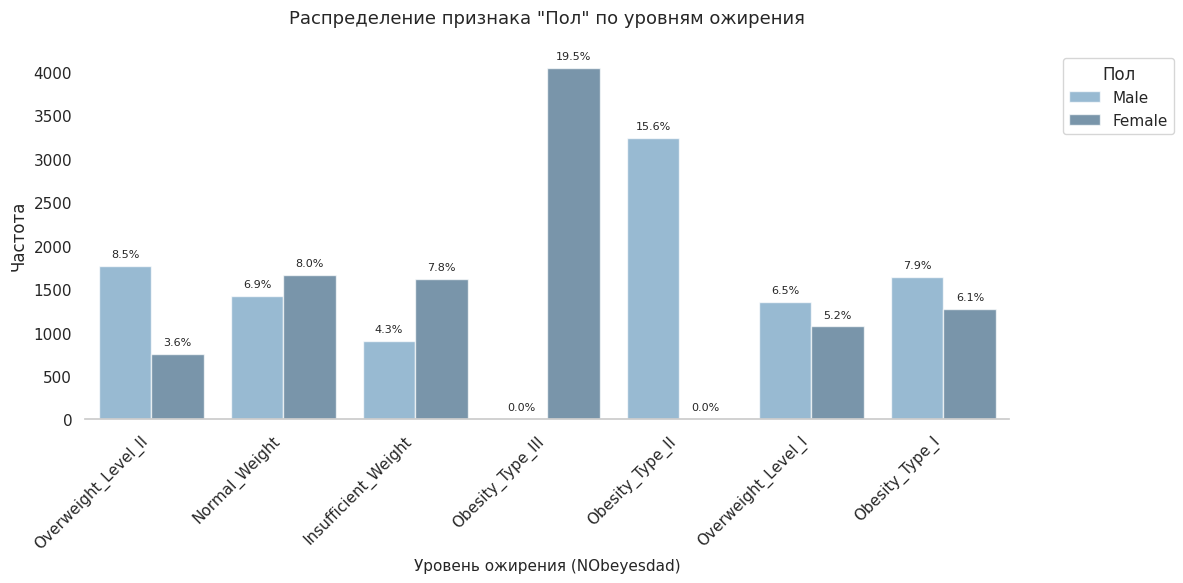

In [367]:
gender_trans = {'Gender': 'Пол'}
plot_target_by_categorical(df, ['Gender'], translations=gender_trans)

**Вывод по анализу переменной пол в разрезе категорий веса**

1. **Экстремальная гендерная сегментация в тяжелых степенях:** Наблюдается практически абсолютное разделение по полу в высших категориях ожирения:
* **Obesity Type II** (Ожирение II степени) почти на **99.8%** представлено **мужчинами**.
* **Obesity Type III** (Ожирение III степени) на **99.9%** представлено **женщинами**.
Это указывает на то, что в данном датасете пол является определяющим фактором для классификации тяжелых форм ожирения.

2. **Недостаточный вес:** Категория **Insufficient Weight** преимущественно представлена **женщинами (64.2%)**, что может свидетельствовать о биологических особенностях или различных социальных установках относительно массы тела среди респондентов.
3. **Избыточный вес (Overweight):** В категориях предожирения (Level I и II) преобладают **мужчины**, причем во второй степени избыточного веса (**Overweight Level II**) их доля достигает **70.1%**, что значительно выше, чем в первой.
4. **Нормальный вес:** Данная категория наиболее сбалансирована, хотя доля женщин в ней несколько выше (**53.9%**).

###**Анализ признака семейная история (family_history_with_overweight)**

In [368]:
print("АНАЛИЗ FAMILY HISTORY ПО КАТЕГОРИЯМ ВЕСА")
family_pivot = pd.crosstab(df['NObeyesdad'], df['family_history_with_overweight'], normalize='index') * 100
display(family_pivot.round(2))

АНАЛИЗ FAMILY HISTORY ПО КАТЕГОРИЯМ ВЕСА


family_history_with_overweight,no,yes
NObeyesdad,,
Insufficient_Weight,57.43,42.57
Normal_Weight,41.92,58.08
Obesity_Type_I,1.65,98.35
Obesity_Type_II,0.15,99.85
Obesity_Type_III,0.02,99.98
Overweight_Level_I,31.15,68.85
Overweight_Level_II,7.65,92.35


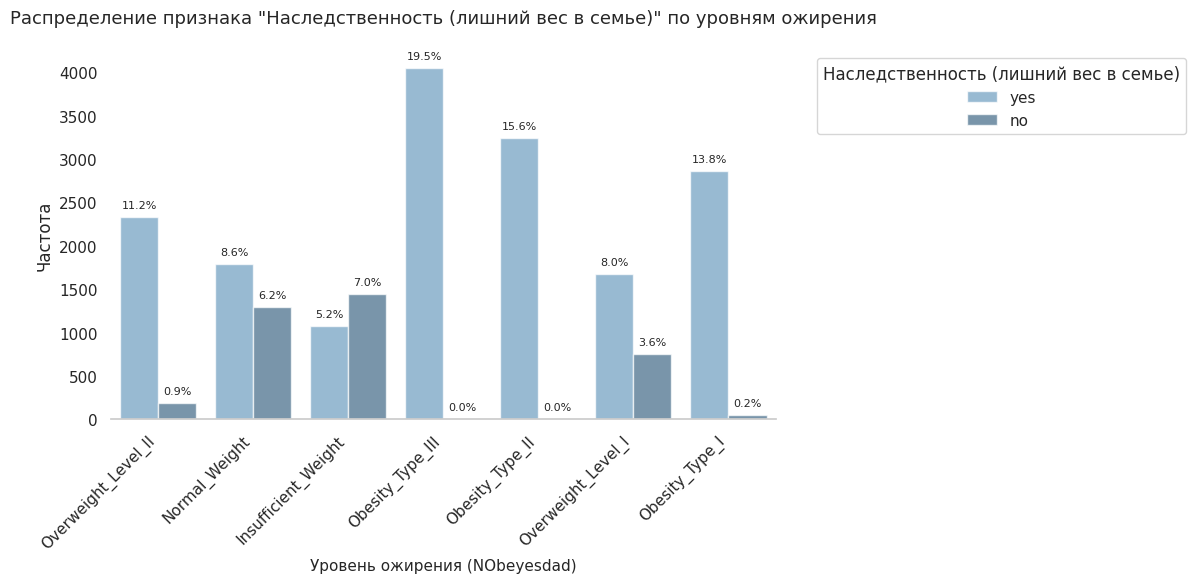

In [369]:
family_trans = {'family_history_with_overweight': 'Наследственность (лишний вес в семье)'}
plot_target_by_categorical(df, ['family_history_with_overweight'], translations=family_trans)

**Вывод по анализу семейной истории в разрезе категорий веса**

* **Критический маркер тяжелого ожирения:** В категориях **Obesity Type II** и **Obesity Type III** наличие семейной истории ожирения составляет практически **100%** (**99.85%** и **99.98%** соответственно). Это означает, что в данном датасете тяжелая степень ожирения почти никогда не встречается без генетической или семейной предрасположенности.
* **Пороговый скачок:** Наблюдается резкий переход между категориями `Normal Weight` (где семейная история есть у **58%**) и `Obesity Type I` (где показатель взлетает до **98%**). Это указывает на то, что семейный фактор является ключевым «триггером» перехода от просто избыточного веса к клиническому ожирению.
* **"Защитный" эффект отсутствия истории:** Группа **Insufficient Weight** (дефицит веса) — единственная, где большинство (**57.4%**) не имеют семейной истории ожирения. Это подтверждает прямую зависимость: отсутствие предрасположенности значительно повышает шансы на сохранение низкого или нормального веса.
* **Динамика прогрессии:** Мы видим четкую ступенчатую корреляцию:
* *Норма:* ~58%
* *Избыточный вес:* 69% → 92%
* *Ожирение:* 98% → 100%
Генетический фактор усиливается пропорционально росту массы тела.

###**Анализ признака употребление калорийной пищи (FAVC)**

In [370]:
print("АНАЛИЗ FAVC ПО КАТЕГОРИЯМ ВЕСА")
favc_target_pivot = pd.crosstab(df['NObeyesdad'], df['FAVC'], normalize='index') * 100
display(favc_target_pivot)

АНАЛИЗ FAVC ПО КАТЕГОРИЯМ ВЕСА


FAVC,no,yes
NObeyesdad,,
Insufficient_Weight,14.665081,85.334919
Normal_Weight,16.060999,83.939001
Obesity_Type_I,3.195876,96.804124
Obesity_Type_II,1.662562,98.337438
Obesity_Type_III,0.024716,99.975284
Overweight_Level_I,9.229501,90.770499
Overweight_Level_II,21.371927,78.628073


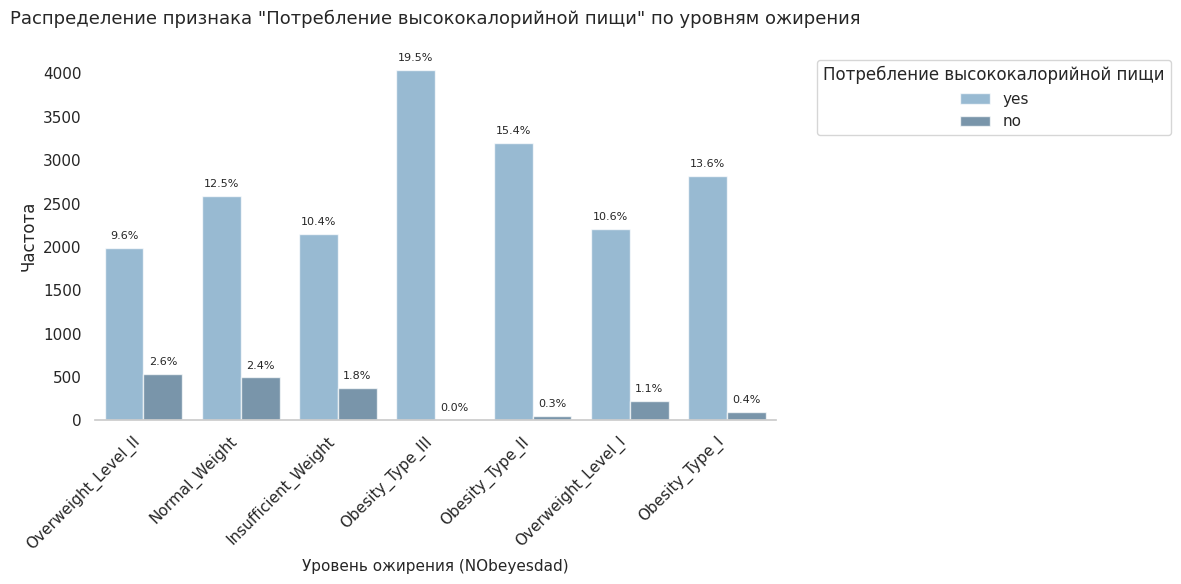

In [371]:
favc_trans = {'FAVC': 'Потребление высококалорийной пищи'}
plot_target_by_categorical(df, ['FAVC'], translations=favc_trans)

**Вывод по анализу FAVC в разрезе категорий веса**

* **Прямая корреляция с ожирением:** Процент потребления высококалорийной пищи достигает критических значений в группах с ожирением. В категории **Obesity_Type_III** он составляет практически **100%** (99.98%), а в **Obesity_Type_II** — **98.3%**. Это подтверждает, что калорийная еда является фундаментальным фактором тяжелых форм ожирения.
* **Аномалия Overweight_Level_II:** Данная группа демонстрирует самый высокий уровень отказа от калорийной пищи (**21.4%** — даже выше, чем у людей с нормальным весом). Это может указывать на то, что респонденты в этой категории чаще других пытаются контролировать диету, находясь на «пороге» перехода к ожирению.
* **Здоровый дефицит:** В категориях `Insufficient_Weight` и `Normal_Weight` доля тех, кто избегает калорийной пищи, составляет около **15-16%**. Это в 5-10 раз выше, чем в группах с ожирением, что подчеркивает защитную роль пищевых привычек.
* **Маркер риска:** Резкое снижение доли ответов «No» (до **3.2%**) при переходе от избыточного веса к `Obesity_Type_I` является четким индикатором того, что потеря контроля над качеством рациона ведет к переходу в стадию клинического ожирения.

###**Анализ признака курение (SMOKE)**

In [372]:
print("АНАЛИЗ SMOKE ПО КАТЕГОРИЯМ ВЕСА")
smoke_pivot = pd.crosstab(df['NObeyesdad'], df['SMOKE'], normalize='index') * 100
display(smoke_pivot)

АНАЛИЗ SMOKE ПО КАТЕГОРИЯМ ВЕСА


SMOKE,no,yes
NObeyesdad,,
Insufficient_Weight,99.722553,0.277447
Normal_Weight,98.507463,1.492537
Obesity_Type_I,99.175258,0.824742
Obesity_Type_II,96.490148,3.509852
Obesity_Type_III,99.901137,0.098863
Overweight_Level_I,98.969922,1.030078
Overweight_Level_II,99.008723,0.991277


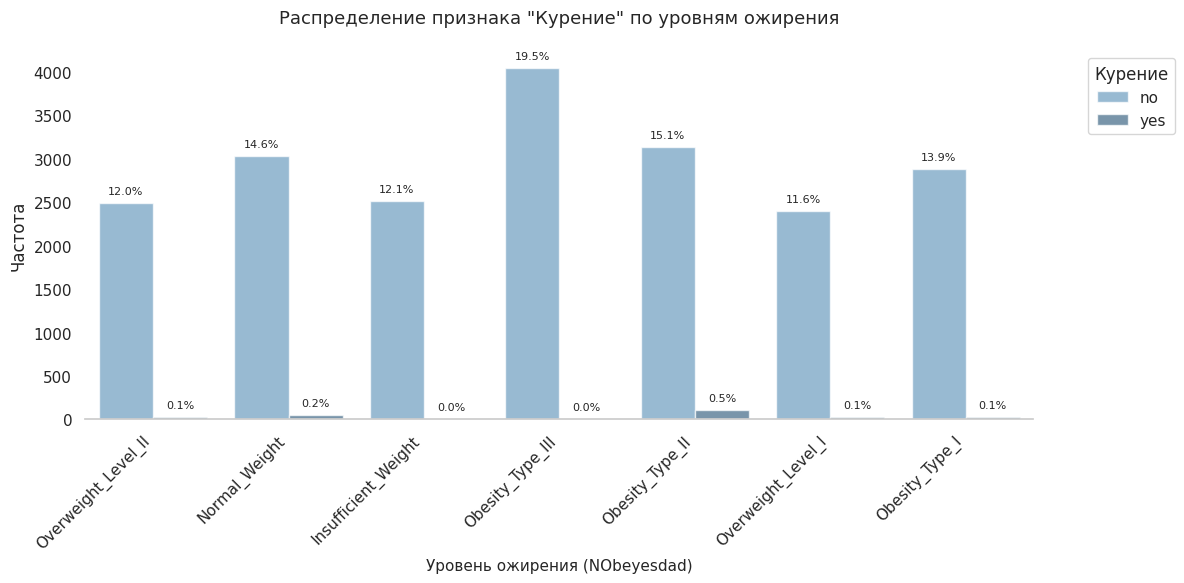

In [373]:
smoke_trans = {'SMOKE': 'Курение'}
plot_target_by_categorical(df, ['SMOKE'], translations=smoke_trans)

**Вывод по анализу курения в разрезе категорий веса**

* **Крайне низкая распространенность:** Курение не является определяющим фактором в данном датасете. В среднем более **98%** респондентов в каждой категории — некурящие. Это делает признак "SMOKE" статистически слабым для предсказания веса.
* **Пик у Obesity Type II:** Самый высокий процент курильщиков зафиксирован в группе **Obesity_Type_II** (**3.5%**). Это единственный сегмент, где доля курящих заметно отклоняется от среднего по выборке.
* **Минимум у Obesity Type III:** У самой тяжелой категории ожирения процент курильщиков практически равен нулю (**0.1%**). Это может указывать на то, что при достижении критической массы тела курение либо заменяется пищевыми зависимостями, либо исключается по состоянию здоровья.
* **Миф о снижении аппетита:** Данные не подтверждают теорию о том, что курение помогает сохранять низкий вес — в категории **Insufficient_Weight** курят всего **0.3%** человек, что почти в 5 раз меньше, чем в группе с нормальным весом.

###**Анализ признака подсчет калорийности (SCC)**

In [374]:
print("АНАЛИЗ SCC ПО КАТЕГОРИЯМ ВЕСА")
scc_pivot = pd.crosstab(df['NObeyesdad'], df['SCC'], normalize='index') * 100
display(scc_pivot)

АНАЛИЗ SCC ПО КАТЕГОРИЯМ ВЕСА


SCC,no,yes
NObeyesdad,,
Insufficient_Weight,90.804598,9.195402
Normal_Weight,94.808566,5.191434
Obesity_Type_I,99.381443,0.618557
Obesity_Type_II,99.876847,0.123153
Obesity_Type_III,100.000000,0.000000
Overweight_Level_I,89.740420,10.259580
Overweight_Level_II,99.048374,0.951626


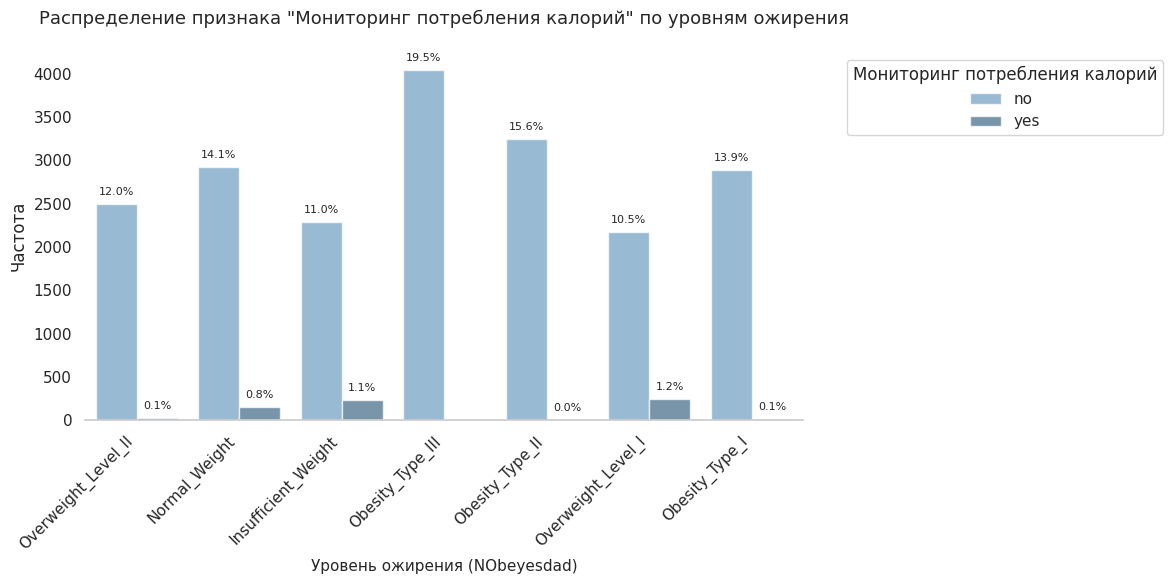

In [375]:
scc_trans = {'SCC': 'Мониторинг потребления калорий'}
plot_target_by_categorical(df, ['SCC'], translations=scc_trans)

**Вывод по анализу SCC в разрезе категорий веса**

* **Отсутствие контроля при ожирении:** Наблюдается критическая динамика — чем выше степень ожирения, тем меньше респонденты следят за калориями. В категории **Obesity_Type_III** мониторинг отсутствует полностью (**0%**), а в **Obesity_Type_II** он близок к нулю (**0.1%**). Это делает SCC одним из самых сильных разделителей между нормой и тяжелым ожирением.
* **Пик осознанности у Overweight I:** Самый высокий уровень контроля калорий зафиксирован в группе **Overweight_Level_I** (**10.3%**). Это подтверждает гипотезу: люди, только начавшие набирать лишний вес, пытаются бороться с этим с помощью инструментов самоконтроля.
* **Дисциплина при дефиците веса:** Группа **Insufficient_Weight** также демонстрирует высокий показатель (**9.2%**), что может быть связано с попытками набора массы через строгий контроль питания.
* **Общий тренд:** Подавляющее большинство респондентов во всех категориях (более **90%**) **не ведут** учет калорий. Однако почти полное исчезновение этого признака в группах ожирения (Type I, II, III) указывает на то, что отсутствие мониторинга является сопутствующим фактором развития болезни.

##**2. Анализ распределения порядковых и номинальных признаков**

In [376]:
ORD_FEAT = ['CAEC', 'CALC', 'MTRANS']
ORD_TRANS = {'CAEC': 'Перекусы', 'CALC': 'Алкоголь', 'MTRANS': 'Транспорт'}

ord_data = []
for f in ORD_FEAT:
    s = df[f].value_counts()
    for i, (val, count) in enumerate(s.items()):
        ord_data.append({'Признак': ORD_TRANS[f], 'Класс': val, 'Количество': count, 'Процент (%)': round(count/len(df)*100, 1),
                         'Мода': s.index[0] if i==0 else '', 'Дисбаланс': f"1:{round(s.max()/s.min(),1)}" if i==0 else ''})

display(HTML(custom_style + generate_styled_table(pd.DataFrame(ord_data), "ПОРЯДКОВЫЕ И НОМИНАЛЬНЫЕ ПРИЗНАКИ")))

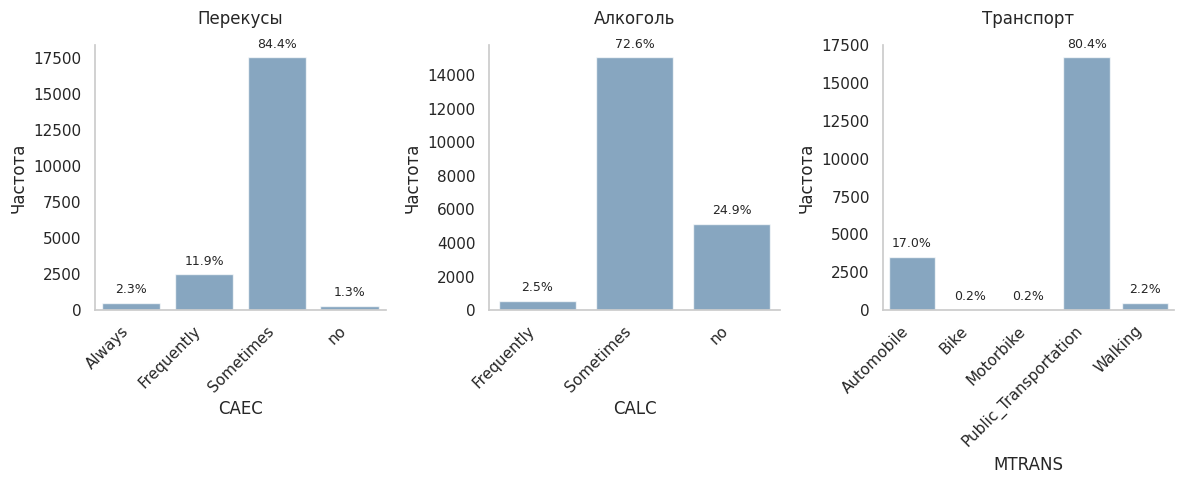

In [377]:
plot_categorical_grid(df, ORD_FEAT, ORD_TRANS, colors='#4682B4')

Данные показатели характеризуют образ жизни и поведенческие паттерны респондентов. Наблюдается выраженное доминирование определенных классов во всех трех признаках:

* **Пищевое поведение (Перекусы):** Выборка крайне однородна — **84.4%** респондентов перекусывают «Иногда» (**Sometimes**). Крайне низкий процент людей, полностью отказывающихся от перекусов (**1.3%**), в сочетании с высоким коэффициентом дисбаланса (**1:62.8**), говорит о том, что данная привычка является нормой для большинства участников исследования.
* **Потребление алкоголя:** Основная часть респондентов (**72.6%**) употребляет алкоголь умеренно. При этом четверть выборки (**24.9%**) отмечает полный отказ от него. Дисбаланс **1:28.5** обусловлен крайне малым числом людей, употребляющих алкоголь часто, что типично для данных самоанкетирования.
* **Транспортная активность:** Наблюдается критический перекос в сторону **общественного транспорта (80.4%)**. Активные способы передвижения (пешком или велосипед) суммарно составляют менее **2.5%**. Это свидетельствует о низком уровне повседневной физической активности, связанной с перемещением, что является важным фактором риска развития ожирения.

Высокий дисбаланс в этих признаках (особенно в транспорте и перекусах) означает, что редкие классы (например, «велосипед» или «отсутствие перекусов») могут стать сильными маркерами специфических групп, если они коррелируют с нормальным весом.

###**Анализ признака употребление алкоголя (CALS)**

In [378]:
print("АНАЛИЗ CALC ПО КАТЕГОРИЯМ ВЕСА")
calc_pivot = pd.crosstab(df['NObeyesdad'], df['CALC'], normalize='index') * 100
display(calc_pivot)

АНАЛИЗ CALC ПО КАТЕГОРИЯМ ВЕСА


CALC,Frequently,Sometimes,no
NObeyesdad,,,
Insufficient_Weight,0.554895,64.209275,35.235830
Normal_Weight,2.206360,62.946139,34.847502
Obesity_Type_I,2.611684,49.621993,47.766323
Obesity_Type_II,0.400246,85.498768,14.100985
Obesity_Type_III,0.000000,100.000000,0.000000
Overweight_Level_I,5.356407,80.758138,13.885455
Overweight_Level_II,9.040444,50.713719,40.245837


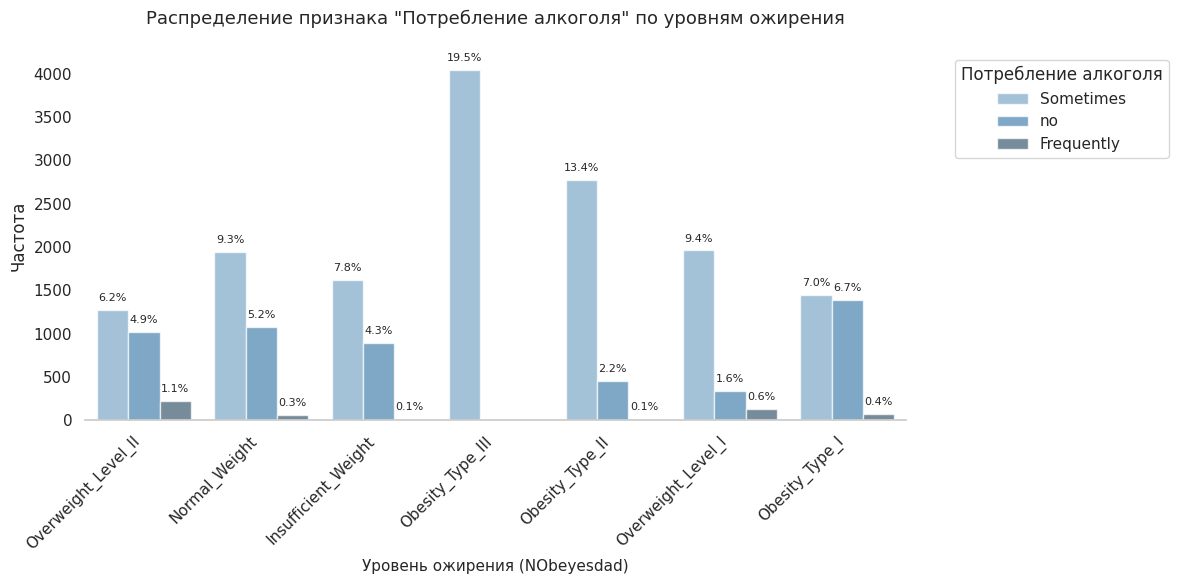

In [379]:
calc_trans = {'CALC': 'Потребление алкоголя'}
plot_target_by_categorical(df, ['CALC'], translations=calc_trans)

**Вывод по анализу алкоголя в разрезе категорий веса**

* **Аномалия Obesity Type III:** Категория с самым тяжелым ожирением демонстрирует уникальное распределение — **100%** респондентов употребляют алкоголь «иногда» (`Sometimes`). При этом среди них полностью отсутствуют как абсолютные трезвенники, так и те, кто пьет «часто». Это указывает на чрезвычайную однородность привычек в этой группе.
* **Пик частого употребления у Overweight II:** Самый высокий процент категории `Frequently` (**9.0%**) наблюдается в группе **Overweight_Level_II**. Это может свидетельствовать о том, что регулярное потребление алкоголя является значимым фактором набора веса именно на этапе перехода от избыточного веса к ожирению.
* **Трезвость и Obesity Type I:** Удивительно, но в категории **Obesity_Type_I** зафиксирован самый высокий уровень полного отказа от алкоголя (**47.8%**). Это может говорить о попытках медицинской коррекции веса или наличии сопутствующих заболеваний, исключающих алкоголь.
* **Общий тренд "Sometimes":** Для большинства категорий (кроме Obesity I) употребление алкоголя «время от времени» является доминирующей нормой (**50–85%**). Это подтверждает, что алкоголь присутствует в рационе большинства людей с избыточной массой тела, внося вклад в общую калорийность питания.

###**Анализ признака способ передвижения (MTRANS)**

In [380]:
print("АНАЛИЗ MTRANS ПО КАТЕГОРИЯМ ВЕСА")
mtrans_pivot = pd.crosstab(df['NObeyesdad'], df['MTRANS'], normalize='index') * 100
display(mtrans_pivot.round(2))

АНАЛИЗ MTRANS ПО КАТЕГОРИЯМ ВЕСА


MTRANS,Automobile,Bike,Motorbike,Public_Transportation,Walking
NObeyesdad,,,,,
Insufficient_Weight,10.98,0.08,0.16,85.85,2.93
Normal_Weight,10.03,0.45,0.55,83.23,5.74
Obesity_Type_I,25.67,0.07,0.14,73.26,0.86
Obesity_Type_II,29.06,0.03,0.09,70.63,0.18
Obesity_Type_III,0.00,0.00,0.00,100.00,0.00
Overweight_Level_I,19.57,0.37,0.29,75.61,4.16
Overweight_Level_II,31.01,0.16,0.12,65.38,3.33


**Вывод по анализу транспорта в разрезе категорий веса**

* **Тотальная зависимость Obesity Type III:** Как и в случае с алкоголем, группа с самым тяжелым ожирением демонстрирует абсолютную однородность — **100%** респондентов используют общественный транспорт. Полное отсутствие автомобилей и прогулок пешком в этой группе может быть связано с социально-экономическими факторами или особенностями сбора данных в этой специфической подгруппе.
* **Личный автомобиль как фактор риска:** Наблюдается четкий рост использования автомобиля при переходе от нормального веса к избыточному. В группах **Obesity Type I** и **Obesity Type II** доля автомобилистов достигает **25-29%**, а пик приходится на **Overweight Level II** (**31%**). Это подтверждает гипотезу о том, что снижение базовой активности (замена ходьбы вождением) коррелирует с лишним весом.
* **Дефицит веса и активность:** Самый высокий уровень передвижения пешком (**Walking**) зафиксирован у людей с нормальным весом (**5.7%**) и дефицитом веса (**2.9%**). С развитием ожирения (Type I-III) этот показатель падает практически до нуля (менее 1%), что указывает на резкое сокращение спонтанной физической нагрузки.
* **Общественный транспорт — основной способ:** Для большинства категорий это доминирующий вид передвижения (от 65% до 85%). Однако его доля снижается в группах с избыточным весом за счет перехода на личные автомобили.

###**Анализ признака перекусы (CAEC)**

In [381]:
print("АНАЛИЗ CAEC ПО КАТЕГОРИЯМ ВЕСА")
caec_pivot = pd.crosstab(df['NObeyesdad'], df['CAEC'], normalize='index') * 100
display(caec_pivot.round(2))

АНАЛИЗ CAEC ПО КАТЕГОРИЯМ ВЕСА


CAEC,Always,Frequently,Sometimes,no
NObeyesdad,,,,
Insufficient_Weight,1.39,48.04,50.26,0.32
Normal_Weight,8.92,22.91,67.00,1.17
Obesity_Type_I,2.20,1.92,95.60,0.27
Obesity_Type_II,0.31,0.37,99.26,0.06
Obesity_Type_III,0.02,0.07,99.90,0.00
Overweight_Level_I,2.47,11.25,77.26,9.02
Overweight_Level_II,1.31,8.33,90.13,0.24


**Вывод по анализу привычек перекусывать (CAEC) в разрезе веса**

* **Доминирование «иногда» у групп с ожирением:** В категориях самого тяжелого ожирения (**Obesity Type II и III**) практически **100%** опрошенных (99.26% и 99.90%) заявляют, что перекусывают лишь «иногда» (`Sometimes`). Это выглядит как статистическая аномалия или «социально одобряемые ответы», так как полное отсутствие категорий `Frequently` и `Always` в этих группах противоречит классической диетологии.
* **Феномен дефицита веса:** Группа **Insufficient Weight** — единственная, где почти половина респондентов (**48%**) признаются, что перекусывают «часто» (`Frequently`). Это может быть связано с особенностями метаболизма (дробное питание) или составом этих перекусов, которые не приводят к набору массы.
* **Нормальный вес и «всегда»:** Самый высокий процент категории `Always` (постоянные перекусы) наблюдается у людей с **Normal Weight** (**8.9%**). Это подтверждает, что сам факт перекуса менее важен, чем общая калорийность рациона и физическая активность.
* **Отказ от перекусов (no):** Интересно, что категория `no` (вообще не перекусываю) наиболее выражена у группы **Overweight Level I** (**9%**). В остальных группах этот показатель близок к нулю.
* **Общий тренд:** По мере роста степени ожирения ответы становятся всё более однообразными — подавляющее большинство выбирает вариант `Sometimes`, практически исключая крайности (`no` или `Always`).

##**3. Анализ распределения целевой переменной (Target)**

In [382]:
target_s = df['NObeyesdad'].value_counts()
target_data = []
for i, (val, count) in enumerate(target_s.items()):
    target_data.append({'Признак': 'Целевая переменная', 'Класс': val, 'Количество': count, 'Процент (%)': round(count/len(df)*100, 1),
                        'Мода': target_s.index[0] if i==0 else '', 'Дисбаланс': f"1:{round(target_s.max()/target_s.min(),1)}" if i==0 else ''})

display(HTML(custom_style + generate_styled_table(pd.DataFrame(target_data), "ЦЕЛЕВАЯ ПЕРЕМЕННАЯ (NOBEYESDAD)")))

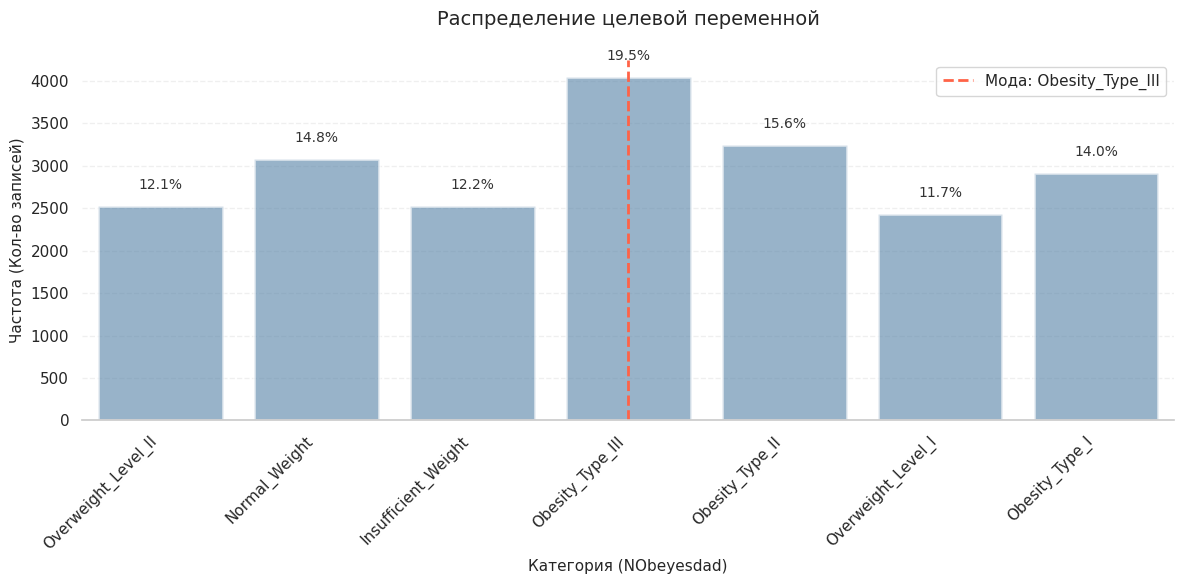

In [383]:
plt.figure(figsize=(12, 6))
ax = sns.countplot(
    data=df,
    x='NObeyesdad',
    color='#4682B4',
    alpha=0.6,
    edgecolor='white',
    linewidth=2
)

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom',
                xytext=(0, 10), textcoords='offset points',
                fontsize=10, color='#333')

mode_category = target_s.index[0]
mode_idx = list(ax.get_xticklabels()).index(next(label for label in ax.get_xticklabels() if label.get_text() == mode_category))
plt.axvline(mode_idx, color='#FF6347', linestyle='--', linewidth=2, label=f'Мода: {mode_category}')

plt.xticks(rotation=45, ha='right')
plt.title('Распределение целевой переменной', fontsize=14, pad=25)
plt.xlabel('Категория (NObeyesdad)', fontsize=11)
plt.ylabel('Частота (Кол-во записей)', fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(frameon=True, loc='upper right')

sns.despine(left=True)
plt.tight_layout()
plt.show()

**Выводы по результатам анализа:**

* **Сбалансированность выборки:** Набор данных демонстрирует **высокую степень сбалансированности**. Доля каждой из семи категорий веса варьируется в узком диапазоне от **11.7%** до **19.5%**. Это является отличным показателем для обучения моделей машинного обучения, так как отсутствует критический перекос в сторону одного класса.
* **Доминирующий класс (Мода):** Наиболее представленной категорией является **Obesity_Type_III** (Ожирение III степени), составляющая **19.5%** (4,046 записей).
* **Показатель дисбаланса:** Коэффициент дисбаланса составляет всего **1:1.7** (соотношение самого малочисленного класса *Overweight_Level_I* к самому многочисленному *Obesity_Type_III*). Такое значение считается незначительным и не требует применения специальных техник ресемплинга (SMOTE или Undersampling).
* **Структура групп:** Суммарно категории, классифицируемые как «Ожирение» (Type I, II, III), составляют почти **50%** выборки, что делает данный датасет специализированным инструментом для изучения тяжелых форм избыточной массы тела.

#**Корреляция**

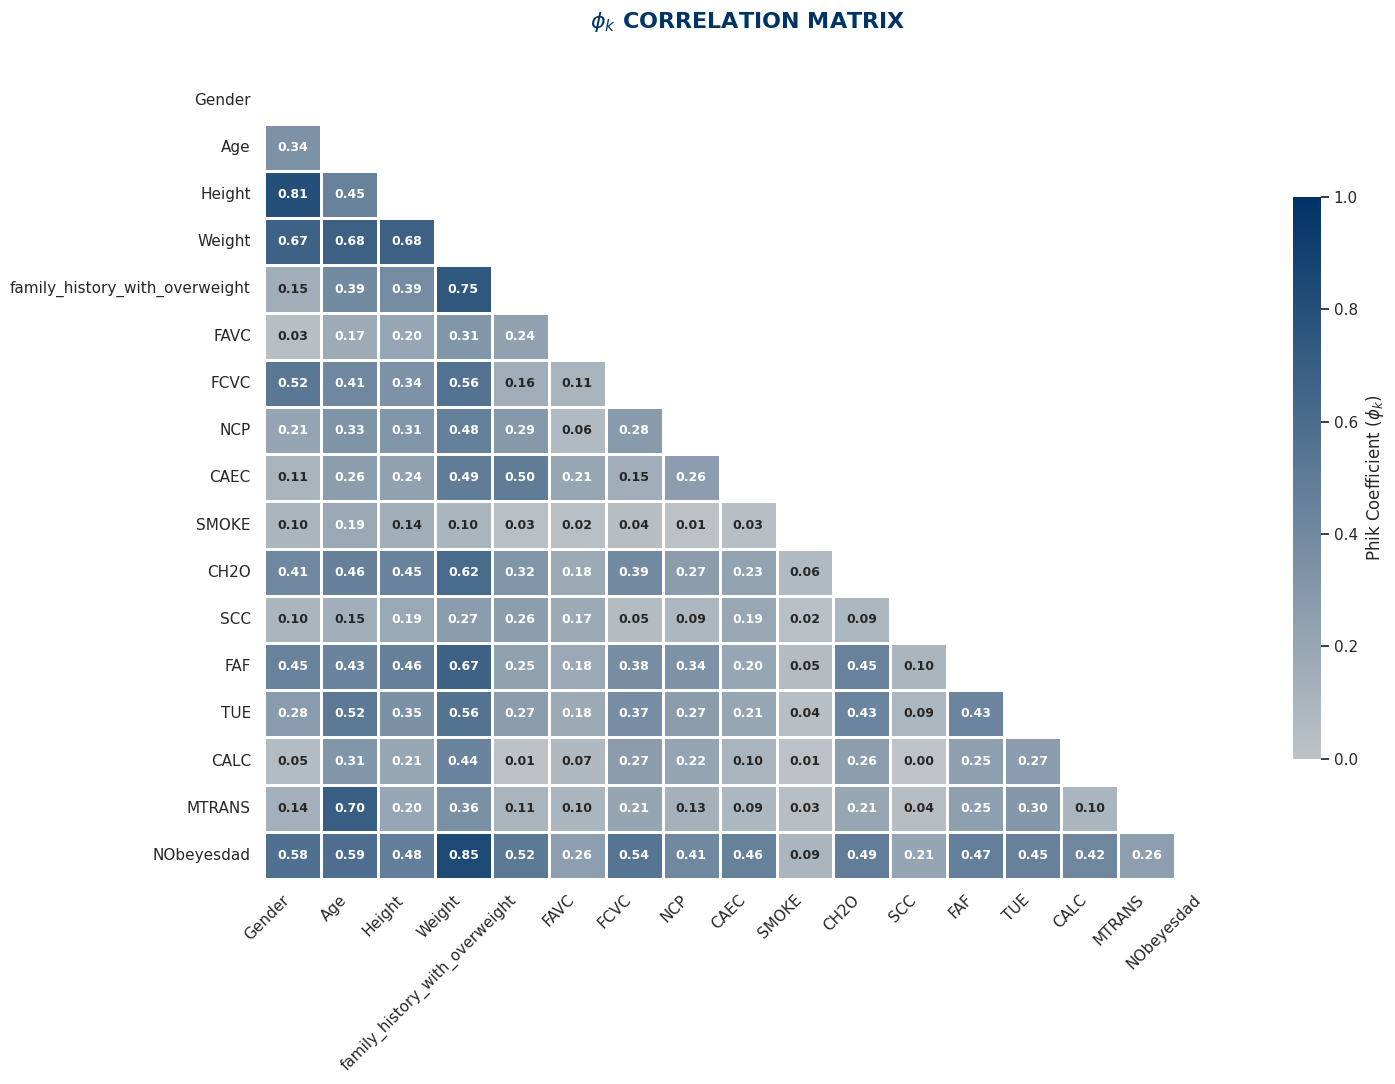

In [384]:
interval_cols = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

my_cmap = LinearSegmentedColormap.from_list("custom_blue", ["#BDC3C7", "#003366"])

plt.figure(figsize=(15, 11), facecolor='white')
sns.set_style("white")
mask = np.triu(np.ones_like(phik_matrix, dtype=bool))

sns.heatmap(
    phik_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap=my_cmap,
    vmin=0, vmax=1,
    linewidths=1,
    cbar_kws={"shrink": .7, "label": r"Phik Coefficient ($\phi_k$)"},
    annot_kws={"size": 9, "weight": "bold"}
)

plt.title(r'$\phi_k$ CORRELATION MATRIX',
          fontsize=16, pad=35, weight='bold', color='#003366', loc='center')

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

sns.despine(left=True, bottom=True)

plt.tight_layout()
plt.show()

In [385]:
print("\nРАНЖИРОВАНИЕ ВСЕХ ПРИЗНАКОВ ПО ВЛИЯНИЮ НА ВЕС (NObeyesdad):")
phik_matrix['NObeyesdad'].sort_values(ascending=False)


РАНЖИРОВАНИЕ ВСЕХ ПРИЗНАКОВ ПО ВЛИЯНИЮ НА ВЕС (NObeyesdad):


,NObeyesdad
NObeyesdad,1.000000
Weight,0.846584
Age,0.590662
Gender,0.575421
FCVC,0.544278
family_history_with_overweight,0.517981
CH2O,0.487920
Height,0.480604
FAF,0.470832
CAEC,0.458571


**Анализ факторов влияния на категорию веса (на основе коэффициента )**

На основе рассчитанной матрицы корреляции Phik, мы можем разделить все признаки на три группы по силе их связи с итоговой категорией веса (**NObeyesdad**). В отличие от стандартных методов,  лучше улавливает нелинейные зависимости, что дает нам более точную картину.

*1. Группа «Критическое влияние» (Correlation > 0.50)*

В эту категорию вошли фундаментальные биологические и наследственные факторы:

* **Weight (0.85):** Абсолютный лидер корреляции. Вес напрямую определяет ИМТ, на котором строится целевая переменная, что подтверждает математическую целостность данных.
* **Age (0.59):** Второй по значимости фактор. Высокий показатель указывает на то, что возрастные изменения метаболизма и накопление поведенческих привычек со временем играют ключевую роль в прогрессии ожирения.
* **Gender (0.58):** Демонстрирует сильную зависимость типов ожирения от пола. Это подтверждает, что физиологические различия между мужчинами и женщинами критичны для классификации веса.
* **FCVC (0.54):** Частота употребления овощей — наиболее значимый диетический фактор. Это «базис», разделяющий группы с нормальным весом и ожирением.
* **Family History (0.52):** Генетическая предрасположенность и семейная среда замыкают группу лидеров, подтверждая статус одного из главных предикторов.

*2. Группа «Значимое влияние» (Correlation 0.40 – 0.49)*

Факторы образа жизни и повседневных привычек:

* **Питьевой режим и активность (CH2O, FAF, TUE):** Потребление воды (**0.49**), физическая нагрузка (**0.47**) и время перед экраном (**0.45**) имеют схожую силу влияния. Это подчеркивает важность комплексного подхода к образу жизни.
* **Пищевое поведение (CAEC, CALC, NCP):** Частота перекусов, употребление алкоголя и количество основных приемов пищи входят в этот блок (**0.41–0.46**), являясь важными уточняющими признаками.

*3. Группа «Слабое влияние» (Correlation < 0.30)*

Признаки, которые вносят вклад, но не являются определяющими сами по себе:

* **Транспорт и калорийная еда (MTRANS, FAVC):** Оба признака имеют коэффициент **0.26**. Это говорит о том, что способ передвижения и употребление фастфуда влияют на вес слабее, чем возраст или овощи в рационе.
* **Мониторинг калорий (SCC, 0.21):** Самоконтроль калорийности имеет низкую корреляцию в данном наборе данных.
* **Курение (SMOKE, 0.09):** Самый слабый признак. Он практически не несет полезной информации для предсказания веса и является кандидатом на исключение из модели.

---

*Итоговое резюме для построения модели:*

Для достижения максимальной точности классификации (метрики -score) необходимо уделить приоритетное внимание признакам из первой группы. Связка **«Вес + Возраст + Пол + Овощи + Наследственность»** создает мощный предсказательный сигнал. В то же время низкое влияние курения (SMOKE) позволяет упростить модель без потери качества, удалив этот признак.

#**Обоснование модели кодирования категориальных переменных**

### **1. Бинарное кодирование (Binary Mapping)**

**Признаки:** `family_history_with_overweight`, `FAVC`, `SMOKE`, `SCC`.

* **Обоснование:** Эти признаки имеют дихотомическую природу (Да/Нет). Перевод их в формат `0/1` является наиболее эффективным, так как он не увеличивает размерность датасета (в отличие от One-Hot) и сохраняет логическую интерпретируемость: `0` — отсутствие фактора, `1` — его наличие.
* Поскольку алгоритмы вычисляют «вес» признака, наличие единицы напрямую указывает на вклад фактора в риск ожирения.

In [386]:
display_horizontal_reports(preprocessor.mappings.get('binary', {}), "БИНАРНЫЕ ПРИЗНАКИ (BINARY ENCODING)")

Значение,Код
no,0
yes,1
Значение,Код
no,0
yes,1
Значение,Код
no,0
yes,1
Значение,Код
no,0


* **Метод:** Все признаки с двумя вариантами ответов (`yes`/`no`) были преобразованы в целочисленный формат `0` и `1`.
* **Логика:** Значение **«0»** назначено для ответа **«no»** (отсутствие признака), значение **«1»** — для **«yes»** (наличие признака).
* **Цель:** Это преобразование позволяет перевести качественные характеристики (наличие вредных привычек или семейного анамнеза) в количественные, сохраняя при этом минимальную размерность данных.

> **Результат:** Данные подготовлены для корреляционного анализа и обучения моделей. Теперь признаки интерпретируются математически: чем выше значение (1), тем выше вклад конкретного фактора в итоговый прогноз веса.

### **2. Порядковое кодирование (Ordinal Encoding)**

**Признаки:** `CAEC`, `CALC` и целевая переменная `NObeyesdad`.

* **Обоснование:** Эти переменные являются **ординальными**. В них заложен внутренний порядок (ранг).
* Для `CAEC/CALC`: *no < Sometimes < Frequently < Always*.
* Для `NObeyesdad`: от дефицита веса до ожирения III степени.
* Использование случайных чисел или One-Hot здесь недопустимо, так как мы потеряем информацию о градации интенсивности привычки. Присвоение индексов `0, 1, 2, 3` позволяет модели понимать, что «Always» — это «больше», чем «Sometimes», что критически важно для выявления трендов роста веса.

In [387]:
display_horizontal_reports(preprocessor.mappings.get('ordinal', {}), "ПОРЯДКОВЫЕ ПРИЗНАКИ (ORDINAL ENCODING)",
                           bg_color='#eef9f2', text_color='#004d00')

Значение,Код
no,0
Sometimes,1
Frequently,2
Always,3
Значение,Код
no,0
Sometimes,1
Frequently,2
Always,3


* **Метод:** Для признаков **CAEC** (перекусы) и **CALC** (алкоголь) применено ранжирование с сохранением внутренней иерархии.
* **Логика:** Значения преобразованы в числовую шкалу от **0 до 3**, где:
* **0 («no»)** — полное отсутствие привычки;
* **3 («Always»)** — максимальная частота/интенсивность.


* **Значимость:** В отличие от простого кодирования, данный метод сообщает модели, что «Sometimes» (1) математически ближе к «no» (0), чем к «Always» (3).

> **Результат:** Такое кодирование критически важно для выявления **линейных зависимостей**: теперь мы можем математически подтвердить, растет ли риск ожирения по мере увеличения частоты перекусов или потребления алкоголя.

In [388]:
target_mapping = {"NObeyesdad": preprocessor.target_map}

display_horizontal_reports(
    target_mapping,
    "КОДИРОВАНИЕ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (TARGET ENCODING)",
    bg_color='#fff5f5',
    text_color='#990000'
)

Значение,Код
Insufficient_Weight,0
Normal_Weight,1
Overweight_Level_I,2
Overweight_Level_II,3
Obesity_Type_I,4
Obesity_Type_II,5
Obesity_Type_III,6


* **Метод:** Для целевого признака **NObeyesdad** использовано порядковое кодирование, превращающее текстовые диагнозы в возрастающую числовую шкалу.
* **Логика:** Категории веса ранжированы от **0 до 6** строго по мере увеличения индекса массы тела и степени риска для здоровья:
* **0** — Дефицит веса (**Insufficient Weight**).
* **1** — Норма (**Normal Weight**).
* **2–3** — Избыточный вес (**Overweight**).
* **4–6** — Три степени клинического ожирения (**Obesity**).


* **Значимость:** Такое преобразование переводит задачу из чистого определения «названия» категории в задачу предсказания «степени тяжести». Это позволяет модели улавливать прогрессию заболевания и минимизировать грубые ошибки (например, модели будет «понятнее», что ошибка между 5 и 6 уровнями менее критична, чем между 1 и 6).

> **Результат:** Целевая переменная полностью готова для использования в алгоритмах классификации и расчета корреляции с факторами образа жизни.

### **3. One-Hot кодирование (OHE)**

**Признаки:** `Gender`, `MTRANS`.

* **Обоснование:** Эти признаки являются **номинальными**. В них нет естественного порядка.
* Мужчина не «больше» женщины.
* Автомобиль не «выше» по рангу, чем общественный транспорт.
* Если бы мы использовали Ordinal Encoding (0, 1, 2...), модель могла бы ошибочно предположить, что среднее арифметическое между «Велосипедом» (0) и «Машиной» (2) — это «Мотоцикл» (1). One-Hot создает независимые бинарные векторы для каждой категории, исключая ложные математические связи между несвязанными понятиями.


In [389]:
display_ohe_reports(preprocessor)

Исходное значение,Новая колонка
Male,Gender_Male
Исходное значение,Новая колонка
Bike,MTRANS_Bike
Motorbike,MTRANS_Motorbike
Public_Transportation,MTRANS_Public_Transportation
Walking,MTRANS_Walking


* **Метод:** Для номинальных признаков (**Gender**, **MTRANS**), не имеющих естественного порядка, применено One-Hot кодирование с параметром `drop_first=True`.
* **Логика:** Каждое уникальное значение превращено в отдельную бинарную колонку. При этом первая категория в каждом признаке удалена и принята за «базовый уровень» (например, отсутствие единицы в `Gender_Male` автоматически означает `Female`).
* **Значимость:** * **Исключение ложных связей:** Модель не будет приписывать «вес» или «ранг» способам передвижения (например, считать, что «Walking» больше «Bike»).
* **Борьба с мультиколлинеарностью:** Удаление первой колонки исключает математическую зависимость между признаками (ловушка фиктивных переменных), что делает модель более стабильной.



> **Результат:** Категориальные данные успешно преобразованы в разреженные векторы, что позволяет алгоритму оценивать вклад каждого пола или вида транспорта независимо друг от друга.

**Итоговое заключение по предобработке данных**

В ходе подготовки датасета была реализована гибридная стратегия кодирования, адаптированная под математическую природу каждого признака. Это позволило трансформировать качественные характеристики в численные векторы без потери информативности.

**Ключевые результаты трансформации:**

* **Математическая корректность:** Использование **Ordinal Encoding** для привычек (`CAEC`, `CALC`) и стадий ожирения (`NObeyesdad`) позволило сохранить физический смысл данных — нарастание интенсивности фактора и тяжести состояния.
* **Оптимизация размерности:** Применение **Binary Mapping** (0/1) и **One-Hot Encoding** с параметром `drop_first=True` позволило избежать «раздувания» датасета и решило проблему мультиколлинеарности (ловушка фиктивных переменных).
* **Интерпретируемость:** Выбранная схема делает модель «прозрачной» — каждый коэффициент будет иметь четкую логику (например, влияние наличия семейной истории или конкретного вида транспорта на итоговый вес).

---

Датасет полностью переведен в числовой формат. Устранены избыточные технические колонки (`id`), а целевая переменная приведена к ранговой шкале, что открывает возможность как для задач классификации, так и для глубокого корреляционного анализа.


#**Выбор метрики качества**

**Этическое и техническое обоснование выбора метрики -score**

В рамках разработки алгоритмического решения для классификации степеней ожирения критически важным является выбор метрики, обеспечивающей баланс между предсказательной способностью и психологической безопасностью конечного пользователя.

**1. Недостаточность метрики Accuracy**

Использование общей точности (`Accuracy`) признано нецелесообразным по двум причинам. Во-первых, наличие дисбаланса классов в исходных данных может привести к ложному завышению показателей. Во-вторых, в контексте превентивной медицины и диетологии `Accuracy` не учитывает качественную разницу между типами ошибок, цена которых в данной предметной области асимметрична.

**2. Анализ рисков и критических ошибок**

Применение -score обусловлено необходимостью жесткой минимизации двух типов угроз, возникающих при работе с деликатными данными о массе тела:

**Ложноотрицательные результаты (Ошибка II рода):**
* *Сценарий:* Алгоритм диагностирует «Normal Weight» при фактическом переходе в стадию «Overweight».
* *Последствия:* Формирование ложного чувства безопасности у пользователя, игнорирование деструктивных привычек и упущение возможности своевременной коррекции образа жизни, что в долгосрочной перспективе ведет к развитию метаболических патологий.


**Ложноположительные результаты (Ошибка I рода):**
* *Сценарий:* Модель ошибочно классифицирует пользователя с нормальным весом в категорию «Obesity Type I».
* *Последствия:* Данный сценарий представляет наибольшую этическую угрозу. Для лиц с нестабильной самооценкой ошибочный вердикт системы может послужить триггером для развития **расстройств пищевого поведения (РПП)**, таких как анорексия или булимия. Необоснованное ограничение рациона под влиянием ИИ-прогноза способно нанести более тяжелый вред здоровью, чем наличие лишнего веса.



**3. -score как инструмент этического контроля**

Математическая природа -score, как среднего гармонического между **Precision** (точностью) и **Recall** (полнотой), делает эту метрику оптимальным «фильтром» безопасности:

* **Precision (Точность)** выступает гарантом достоверности: если система прогнозирует риск, это должно соответствовать реальности, исключая необоснованную стигматизацию пользователя и провокацию РПП.
* **Recall (Полнота)** обеспечивает охват: система не должна игнорировать тех, кто объективно нуждается в изменении поведенческих паттернов для сохранения здоровья.

**4. Роль метрики в поведенческой психологии приложения**

Поскольку модель интегрируется в приложение-трекер привычек, точность прогноза напрямую влияет на уровень доверия к системе.

* В условиях низкой прогностической точности любые рекомендации по отказу от вредных привычек (например, курения) теряют авторитетность.
* Отсутствие корректной динамики в прогнозах после реальных усилий пользователя (например, перехода на здоровое питание) провоцирует когнитивный диссонанс и **резкую демотивацию**, что нивелирует терапевтический эффект приложения.

---

**Заключение:**

В качестве ключевого критерия оценки моделей принята метрика **-score (Weighted)**. Данный выбор продиктован принципом профессиональной ответственности перед пользователем. В деликатной сфере антропометрического контроля недопустимы ни «ложные диагнозы», способствующие развитию психопатологий, ни «ложное спокойствие», маскирующее реальные угрозы здоровью. **-score** в данном проекте рассматривается не просто как математический индикатор, а как стандарт этической безопасности цифрового продукта.
